<a href="https://colab.research.google.com/github/TKCreal/Mathematical-modelling-of-beer-production/blob/main/trab_modelellis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import math
import time

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

caminho_para_pasta_do_notebook = '/content/drive/MyDrive/trab_final_modelellis/'
caminho_datasets_csv = caminho_para_pasta_do_notebook + 'datasets.csv'

Mounted at /content/drive


In [ ]:
caminho_datasets_csv = '/content/datasets.csv'

# Beer Fermentation Model

In [ ]:
class BeerODEModel:

    ALL_PARAMS = [
        'mu_x0', 'mu_s0', 'mu_L', 'mu_dy', 'mu_ab',
        'mu_DT', 'mu_SD0', 'mu_e0', 'k_e', 'k_x', 'k_s'
    ]

    DEFAULT_PARAMS = {
        'mu_x0': 0.1, 'mu_s0': 0.2, 'mu_L': 0.05,
        'mu_dy': 0.00013, 'mu_ab': 0.01, 'mu_DT': 0.001,
        'mu_SD0': 0.08, 'mu_e0': 0.285, 'k_e': 12.5, 'k_x': 10, 'k_s': 0.24
    }

    def __init__(self, y0, temperature_varying_params=False, fixed_params=None):
        self.y0 = y0
        self.t_lag = True

        self.temperature_varying_params = temperature_varying_params

        if fixed_params is None:
            fixed_params = {}

        self.varying_param_names = [name for name in self.ALL_PARAMS if name not in fixed_params]
        self.params = self.DEFAULT_PARAMS.copy()
        self.params.update(fixed_params)

    def get_y0(self):
        return self.y0

    def reset_phase(self):
        self.t_lag = True

    def temperature_profile(self,t):
        if t < 0:
          return 0
        elif t <= 30:
          return 10
        elif t <= 50:
          return 10 + (t - 30) * (15 - 10) / (50 - 30)
        elif t <= 140:
          return 15
        elif t <= 170:
          return 15 - (t - 140) * (15 - 3) / (170 - 140)
        else:
          return 3

    def __call__(self, t, y, AB, T=(285.15)):

        if not(self.temperature_varying_params):
          for i, name in enumerate(self.varying_param_names):
            self.params[name] = AB[i]

        else:
          for i, name in enumerate(self.ALL_PARAMS):
            parameters = AB.copy()
            parameters = parameters.reshape((int(len(AB)/2),-1))
            A, B = parameters[i]
            self.params[name] = self.arrhenius(A, B, T)

        return self.ode(y, self.params, T)

    def arrhenius(self, A, B, T=(285.15)):
        return arrhenius(T, A, B)

    def ode(self, y, current_params, T=(285.15)):
        mu_x0, mu_s0, mu_L, mu_dy, mu_ab, mu_DT, mu_SD0, mu_e0, k_e, k_x, k_s = [
            current_params[name] for name in self.ALL_PARAMS]
        Ce0, Cs0, Cdy0, X_act0, X_lag0, X_dead0 = self.y0
        Ce, Cs, Cdy, X_act, X_lag, X_dead = y

        if (X_act >= 0.8 * X_lag0) and self.t_lag:
            self.t_lag = False

        mu_SD = (mu_SD0 * 0.5 * Cs0) / (0.5 * Cs0 + Ce)
        mu_x = (mu_x0 * Cs) / (k_x + Ce)
        mu_s = (mu_s0 * Cs) / (k_s + Cs)
        f = 1 - Ce / (0.5 * Cs0)
        mu_e = (mu_e0 * Cs) / (k_e + Cs)

        if self.t_lag:
            dX_act = mu_L * X_lag
            dX_dead = -mu_SD * X_dead
            dCs = 0.0
            dCe = 0.0
            dCdy = 0.0
        else:
            dX_act = mu_x * X_act - mu_DT * X_act + mu_L * X_lag
            dX_dead = mu_DT * X_act - mu_SD * X_dead
            dCs = -mu_s * X_act
            dCe = f * mu_e * X_act
            dCdy = mu_dy * Cs * X_act - mu_ab * Cdy * Ce
        dX_lag = -mu_L * X_lag

        state_var = np.stack((dCe, dCs, dCdy, dX_act, dX_lag, dX_dead))
        return state_var

# Data import

Arquivo datasets.csv carregado com sucesso!
      0     1      2     3      4       5      6     7
0 -1.72  4.09  -0.53  1.72   2.39  109.62  12.00  0.13
1  0.00  3.70   1.15  1.71   6.37  109.62  15.43  0.21
2  3.44  3.46   3.96  2.05   9.56  108.33  18.29  0.35
3  5.15  3.16   7.35  3.76  12.75  105.77  23.43  0.52
4  7.44  2.82  10.14  3.75  17.53  102.56  28.57  0.92


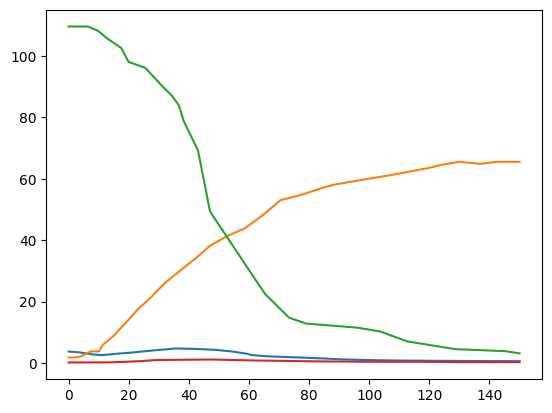

In [ ]:
try:
    df = pd.read_csv(caminho_datasets_csv,header=None, decimal=',')
    print("Arquivo datasets.csv carregado com sucesso!")
    print(df.head())
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado em {caminho_datasets_csv}")
    print("Verifique se o nome da pasta e do arquivo estão corretos e se o arquivo existe na pasta compartilhada.")
    print("Certifique-se de que a pasta compartilhada foi adicionada como um atalho ao 'Meu Drive' se estiver usando o caminho 'MyDrive'.")

df.sort_values(by=df.columns[0], inplace=True)
ex_time,y = [],[]

for i in df.columns:
    if i % 2 == 0:
        column = df[i].dropna()
        ex_time.append(column.values)
    elif i % 2 != 0:
      column = df[i].dropna()
      y.append(column.values)

common_time_points = np.linspace(0, 150, 1500)

for i in range(len(ex_time)):
    interpolated_y = np.interp(common_time_points, ex_time[i], y[i])
    y[i] = interpolated_y

for i in range(len(y)):
  plt.plot(common_time_points,y[i])
plt.show()

# mu_SD0 calc

In [ ]:
print(y[0][0:30])

[3.7        3.6930186  3.6860372  3.6790558  3.67207441 3.66509301
 3.65811161 3.65113021 3.64414881 3.63716741 3.63018602 3.62320462
 3.61622322 3.60924182 3.60226042 3.59527902 3.58829762 3.58131623
 3.57433483 3.56735343 3.56037203 3.55339063 3.54640923 3.53942784
 3.53244644 3.52546504 3.51848364 3.51150224 3.50452084 3.49753944]


In [ ]:
index_tlag = np.argmin(y[0][0:30])
tlag = common_time_points[index_tlag]
print(tlag,index_tlag)

2.9019346230820546 29


mu_SD0 calculado:  [0.0380697] 
mu_SD0 do artigo:  0.2551324912353819


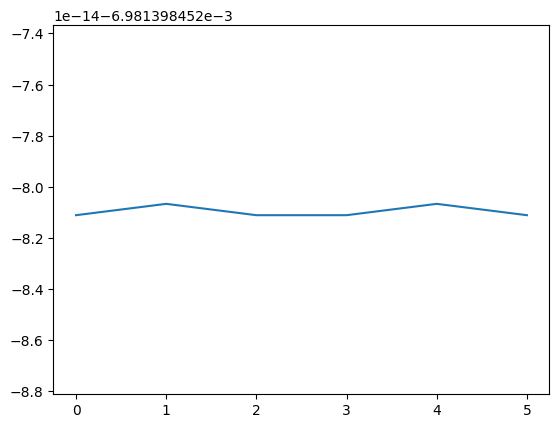

In [ ]:
X_sus_k1 = np.delete(y[0][0:7],0)
# print(X_sus_k1)
X_sus_k = np.delete(y[0][0:7],-1)
# print(X_sus_k)
y_vec = X_sus_k1 - X_sus_k
plt.plot(y_vec)
period = common_time_points[1] - common_time_points[0]
phi = (period * (y[0][0]/2 - X_sus_k)).reshape(1,-1)
phi_T = phi.reshape(-1, 1)
pseudo_inverse = np.linalg.pinv(phi_T)
theta = np.dot(pseudo_inverse,y_vec)
print('mu_SD0 calculado: ',theta,'\nmu_SD0 do artigo: ', np.exp(33.82 - 10033.28/285.15))


# Parâmetros iniciais para estimação

In [ ]:
# --- Suas funções de cálculo de parâmetros ---
def arrhenius(T_kelvin, A, B):
    return np.exp(A + B / T_kelvin)

# --- Definição da estrutura dos parâmetros e como obter os coeficientes ---
# (nome_param, tipo_função, numero_de_coeficientes_reais_a_ajustar)
param_structure_definitions = [
    {'name': 'mu_x0',  'type': 'arrhenius', 'num_coeffs': 2}, # A, B
    {'name': 'mu_s0',  'type': 'arrhenius', 'num_coeffs': 2}, # A, B
    {'name': 'mu_L',   'type': 'arrhenius', 'num_coeffs': 2}, # A, B
    {'name': 'mu_dy',  'type': 'arrhenius',    'num_coeffs': 2}, # c2, c1, c0
    {'name': 'mu_ab',  'type': 'arrhenius',    'num_coeffs': 2}, # c2, c1, c0
    {'name': 'mu_DT',  'type': 'arrhenius', 'num_coeffs': 2}, # A, B
    {'name': 'mu_SD0', 'type': 'arrhenius', 'num_coeffs': 2}, # A, B
    {'name': 'mu_e0',  'type': 'arrhenius', 'num_coeffs': 2}, # A, B
    {'name': 'k_e',    'type': 'arrhenius', 'num_coeffs': 2}, # A, B
    {'name': 'k_x',    'type': 'arrhenius', 'num_coeffs': 2}, # A, B
    {'name': 'k_s',    'type': 'arrhenius', 'num_coeffs': 2}  # A, B
]

# --- Nova função param_vec_fittable ---
def param_vec(T_kelvin, fittable_coeffs_flat):
    """
    Calcula os 10 parâmetros cinéticos a partir de um vetor achatado
    contendo apenas os coeficientes que estão sendo ajustados.

    Args:
        T_kelvin (float): Temperatura em Kelvin.
        fittable_coeffs_flat (numpy.ndarray): Vetor 1D com os 22 coeficientes ajustáveis.

    Returns:
        list: Lista dos 10 parâmetros cinéticos calculados.
    """
    calculated_kinetic_params = []
    current_idx = 0
    for p_info in param_structure_definitions:
        num_c = p_info['num_coeffs']
        coeffs_for_current_param = fittable_coeffs_flat[current_idx : current_idx + num_c]

        if p_info['type'] == 'arrhenius':
            A, B = coeffs_for_current_param
            calculated_kinetic_params.append(arrhenius(T_kelvin, A, B))

        current_idx += num_c

    return calculated_kinetic_params

# --- Como construir seus parâmetros iniciais para o least_squares ---
# Use seu AB_constants_initial (o array 10x3) para popular isso
AB = np.array([
    (108.31, -31934.09),                # mu_x0 (A, B)
    (-41.92, 11654.64),                 # mu_s0 (A, B)
    (30.72, -9501.54),                  # mu_L (A, B)
    (0.013342, 0),                      # mu_dy (A, B)
    (0.334479, 0),                      # mu_ab (A, B)
    (130.16, -38313),                   # mu_DT (A, B)
    (33.82, -10033.28),                 # mu_SD0 (A, B)
    (3.27, -1267.24),                   # mu_e0 (A, B)
    (-119.63, 34203.95),                # k_e (A, B)
    (0.5,0),                            # k_x (A, B)
    (-119.63,34203.95)                  # k_s (A, B)
])

initial_guess = []
for i, p_info in enumerate(param_structure_definitions):
    if p_info['type'] == 'arrhenius':
        # Pega A e B do seu array 10x3
        initial_guess.extend(AB[i, :2])

initial_guess = np.array(initial_guess)

lin_initial_guess = np.array(param_vec(285.15, initial_guess))
print(lin_initial_guess.shape)

lower_bounds = np.full(len(lin_initial_guess),0)
upper_bounds = lin_initial_guess + 100

(11,)


[(np.float64(0.011429823709416054), np.float64(0.5356363249114676)), (np.float64(0.11493082333691548), np.float64(0.467973735969923)), (np.float64(0.05862698889123461), np.float64(0.1841746004585104)), (np.float64(1.0134314016384303), np.float64(1.0134314016384303)), (np.float64(1.397212247977989), np.float64(1.397212247977989)), (np.float64(0.005799947518355829), np.float64(0.5861474705036923)), (np.float64(0.19898920946963158), np.float64(0.666473611315744)), (np.float64(0.2995398900619373), np.float64(0.3489459857185834)), (np.float64(0.05219849120889993), np.float64(3.2155130746624416)), (np.float64(1.6487212707001282), np.float64(1.6487212707001282)), (np.float64(0.05219849120889993), np.float64(3.2155130746624416))]


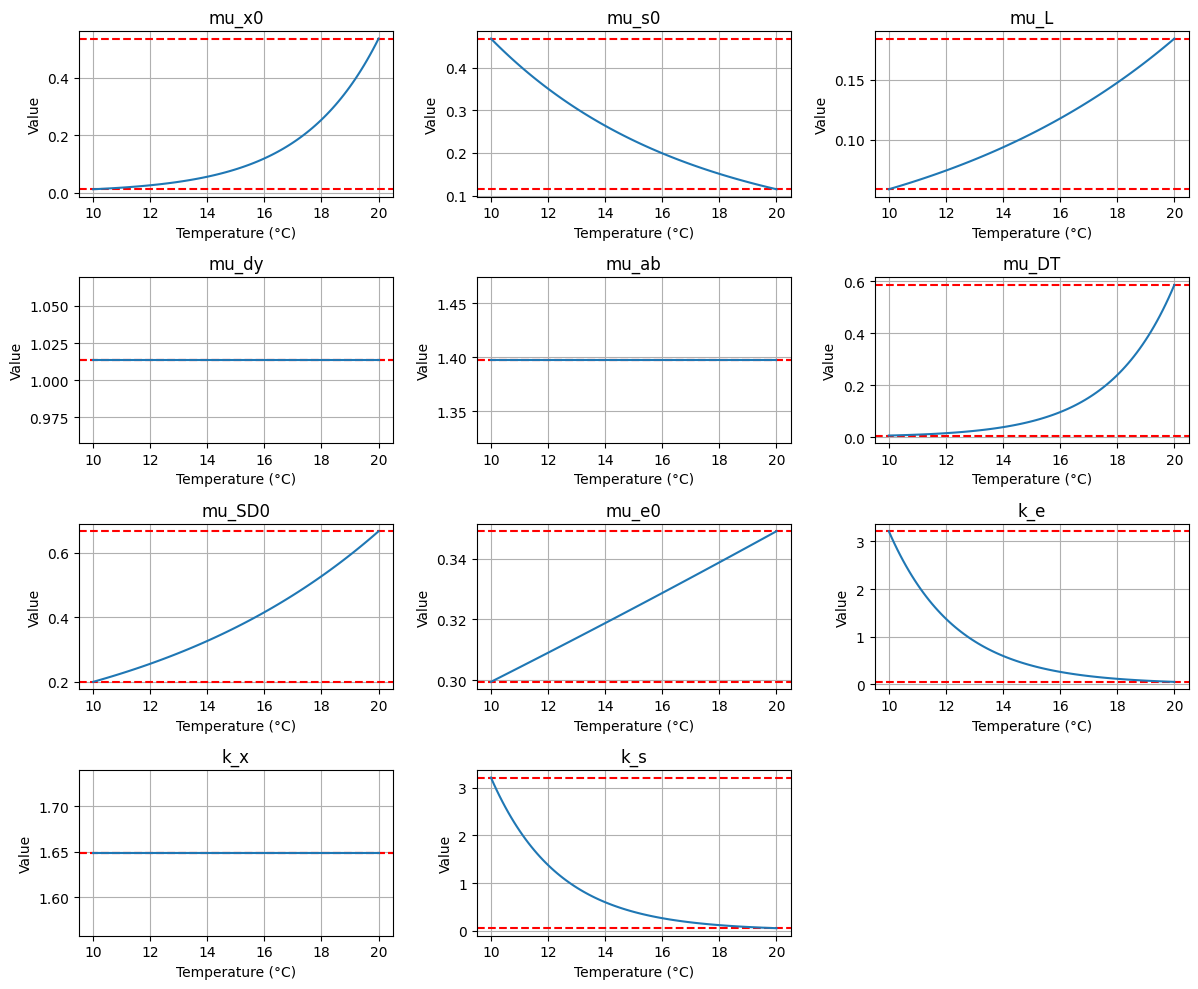

In [ ]:
# --- Plotting the parameter functions vs Temperature ---

# Define the temperature range in Celsius
T_celsius_range = np.linspace(10, 20, 100) # 100 points between 10 and 50 C

# Convert Celsius to Kelvin
T_kelvin_range = T_celsius_range + 273.15

# Calculate the parameters for the entire temperature range using the initial coefficients (AB)
# param_vec now handles array input for T_kelvin
calculated_params_over_T = param_vec(T_kelvin_range, initial_guess)

# Plotting
plt.figure(figsize=(12, 10)) # Adjust figure size as needed

bounds = []
for i, p_info in enumerate(param_structure_definitions):
    plt.subplot(4, 3, i + 1) # Arrange in 4 rows, 3 columns
    lower = min(calculated_params_over_T[i])
    upper = max(calculated_params_over_T[i])
    plt.axhline(y=lower, color='r', linestyle='--')
    plt.axhline(y=upper, color='r', linestyle='--')
    plt.plot(T_celsius_range, calculated_params_over_T[i])
    plt.title(p_info['name'])
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Value')
    plt.grid(True)
    bounds.append((lower, upper))
print(bounds)

plt.tight_layout() # Adjust layout to prevent titles/labels overlapping
plt.show()

# residuals for minsquare

In [ ]:
def residuals(AB, beer_fermentation_model, t_eval_res, y, T):
    # Simular o modelo com os parâmetros atuais
    start_time = time.perf_counter()
    try:
      y0 = beer_fermentation_model.get_y0()
      beer_fermentation_model.reset_phase()
      sol_sim = solve_ivp(
          beer_fermentation_model,
          [t_eval_res[0], t_eval_res[-1]],
          y0,
          method='BDF',
          t_eval=t_eval_res,
          # dense_output=True,
          args=(AB, T)
      )
    except Exception as e:
        print(f"Error during simulation: {e}")
        return 1e12

    # sol_sim.sol(ex_time[i])[j]

    if not sol_sim.success:
        # Se a integração falhar, retornar um erro grande
        return 1e6

    sim_data_combined = (sol_sim.y[:3]).T
    X_sus = np.expand_dims((np.sum(sol_sim.y[4:],axis=0)), axis=1)
    sim_data_combined = np.concatenate((X_sus, sim_data_combined), axis=1)
    sim_data_flattened = sim_data_combined.ravel()
    if np.isinf(sol_sim.y).any() or np.isnan(sol_sim.y).any():
      return 1e6

    y = y.T
    err_per_state = [np.mean((sim_data_combined[:,i] - y[:,i])**2).item() for i in range(y.shape[1])]
    print('SAIDAS: Xsus - Cs - Ce - Cdy')
    print(f'MSE POR SAÍDA: {[f"{e:.2f}" for e in err_per_state]}')

    MAPE_per_state = [np.mean(np.abs((sim_data_combined[:,i] - y[:,i])/y[:,i]))*100 for i in range(y.shape[1])]

    print(f'MAPE POR SAÍDA: {[f"{e:.2f}" for e in MAPE_per_state]}')

    err = sim_data_flattened - y.ravel()

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    print(f"The execution time was: {execution_time:.4f} seconds")
    print(f'erro: {np.mean(err**2)}\n')


    return err



In [ ]:
def residuals_scalar(AB, beer_fermentation_model, t_eval_res, y, T):
    return np.sum(residuals(AB, beer_fermentation_model, t_eval_res, y, T)**2)

# initial conditions

In [ ]:
# condicoes iniciais
X_sus0 = y[0][0]
Ce0 = 0
Cs0 = y[2][0]
Cdy0 = 0
X_act0 = X_sus0*0.02
X_lag0 = X_sus0*0.48
X_dead0 = X_sus0/2

y0 = (np.array([Ce0, Cs0, Cdy0, X_act0, X_lag0, X_dead0]))

t_eval = (common_time_points)
y_true = (np.array(y).copy())

T = (285.15)

# Teste de modelos em teste isotérmico a 285º K

## Some helper functions and bound definitions

In [ ]:
# Helper function to get the initial guess for only the varying parameters
def get_varying_initial_guess(model_instance, full_initial_guess, full_lower_bounds, full_upper_bounds):
    initial_guess_varying = []
    lower_bounds_varying = []
    upper_bounds_varying = []

    # Create a mapping from parameter name to its index in the full lists
    full_param_names = BeerODEModel.ALL_PARAMS
    param_name_to_index = {name: i for i, name in enumerate(full_param_names)}

    for param_name in model_instance.varying_param_names:
        index_in_full = param_name_to_index[param_name]
        initial_guess_varying.append(full_initial_guess[index_in_full])
        lower_bounds_varying.append(full_lower_bounds[index_in_full])
        upper_bounds_varying.append(full_upper_bounds[index_in_full])

    return np.array(initial_guess_varying), np.array(lower_bounds_varying), np.array(upper_bounds_varying)


In [ ]:
def update_model_params(model_instance, optimized_params_vector):
    """Updates the model instance's params dictionary with optimized values."""
    if len(optimized_params_vector) != len(model_instance.varying_param_names):
        print("Warning: Length of optimized parameters does not match varying parameters.")
        return

    # Create a dictionary from varying parameter names and optimized values
    optimized_varying_params = dict(zip(model_instance.varying_param_names, optimized_params_vector))

    # Update the model instance's params dictionary
    model_instance.params.update(optimized_varying_params)
    print(f"Parameters updated for model with varying parameters: {model_instance.varying_param_names}")


In [ ]:
lower_bounds = np.full(len(lin_initial_guess),0)
upper_bounds = lin_initial_guess + 100
init = param_vec(285.15, initial_guess)

## 5 models def and fit to data

In [ ]:
#@title 1: modelo variando TODOS os parâmetros
all_params_to_vary_model = BeerODEModel(y0, temperature_varying_params=False)
init1, lb1, ub1 = get_varying_initial_guess(all_params_to_vary_model, lin_initial_guess,lower_bounds,upper_bounds)
# all_params_to_vary_model.t_lag = False

result_MS_1 = least_squares(
    residuals,
    (init1) ,
    args=(all_params_to_vary_model, t_eval, y_true,T),
    bounds=(lb1,ub1),
    method='trf',
    ftol = 1e-12,
    xtol = 1e-12,
    gtol = 1e-12,
    loss='soft_l1',
    verbose=1, # 0: sem output, 1: output no término, 2: output detalhado a cada iteração
    jac='2-point'
)

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.46', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.0587 seconds
erro: 633.4836004038344

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.47', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.0538 seconds
erro: 633.4838043948436

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.47', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.0659 seconds
erro: 633.4836041667658

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.47', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.0552 seconds
erro: 633.4836144177953

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.46', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.0645 seconds
erro: 633.

In [ ]:
#@title 2: modelo variando todos os parâmetros EXCETO o mu_SD0 que foi achado com minimos quadrados na fase latente
fixed_params_mu_SD0 = {'mu_SD0': BeerODEModel.DEFAULT_PARAMS['mu_SD0']}
varying_all_except_mu_SD0_model = BeerODEModel(y0, temperature_varying_params=False, fixed_params=fixed_params_mu_SD0)
init2, lb2, ub2 = get_varying_initial_guess(varying_all_except_mu_SD0_model, lin_initial_guess, lower_bounds, upper_bounds)

result_MS_2 = least_squares(
    residuals,
    (init2) ,
    args=(varying_all_except_mu_SD0_model, t_eval, y_true,T),
    bounds=(lb2,ub2),
    method='trf', # Trust Region Reflective, bom para problemas com limites
    ftol = 1e-12,
    xtol = 1e-12,
    gtol = 1e-12,
    loss='soft_l1',
    verbose=1, # 0: sem output, 1: output no término, 2: output detalhado a cada iteração
    jac='2-point'
)

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['9.20', '182.96', '1033.49', '1407.82']
MAPE POR SAÍDA: ['236.02', '36.70', '82.90', '1982.67']
The execution time was: 0.0804 seconds
erro: 658.3680370225196

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['9.20', '182.96', '1033.49', '1407.82']
MAPE POR SAÍDA: ['236.02', '36.70', '82.90', '1982.67']
The execution time was: 0.0695 seconds
erro: 658.3682492794555

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['9.20', '182.96', '1033.49', '1407.82']
MAPE POR SAÍDA: ['236.02', '36.70', '82.90', '1982.67']
The execution time was: 0.0756 seconds
erro: 658.3680406689998

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['9.20', '182.96', '1033.49', '1407.82']
MAPE POR SAÍDA: ['236.02', '36.70', '82.90', '1982.67']
The execution time was: 0.0757 seconds
erro: 658.3680836903038

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['9.20', '182.96', '1033.49', '1407.82']
MAPE POR SAÍDA: ['236.02', '36.70', '82.90', '1982.67']
The execution time was: 0.0799 seconds


In [ ]:
#@title 3: modelo variando mu_ab e mu_dy que nao foram dados em lei de arrhenius pelo artigo
fixed_params_except_muab_mudy = {
    name: BeerODEModel.DEFAULT_PARAMS[name]
    for name in BeerODEModel.ALL_PARAMS if name not in ['mu_ab', 'mu_dy']
}
varying_muab_mudy_model = BeerODEModel(y0, temperature_varying_params=False, fixed_params=fixed_params_except_muab_mudy)
init3, lb3, ub3 = get_varying_initial_guess(varying_muab_mudy_model, lin_initial_guess, lower_bounds, upper_bounds)

result_MS_3 = least_squares(
    residuals,
    (init3) ,
    args=(varying_muab_mudy_model, t_eval, y_true,T),
    bounds=(lb3,ub3),
    method='trf', # Trust Region Reflective, bom para problemas com limites
    ftol = 1e-12,
    xtol = 1e-12,
    gtol = 1e-12,
    loss='soft_l1',
    verbose=1, # 0: sem output, 1: output no término, 2: output detalhado a cada iteração
    jac='2-point'
)

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['3.62', '153.60', '578.02', '2482.59']
MAPE POR SAÍDA: ['111.54', '37.55', '77.63', '1221.59']
The execution time was: 0.0631 seconds
erro: 804.4573782252328

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['3.62', '153.60', '578.02', '2482.59']
MAPE POR SAÍDA: ['111.54', '37.55', '77.63', '1221.59']
The execution time was: 0.0480 seconds
erro: 804.4573967528414

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['3.62', '153.60', '578.02', '2482.59']
MAPE POR SAÍDA: ['111.54', '37.55', '77.63', '1221.59']
The execution time was: 0.0502 seconds
erro: 804.4573625144574

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['3.62', '153.58', '578.14', '46.94']
MAPE POR SAÍDA: ['111.58', '37.55', '77.63', '238.36']
The execution time was: 0.0478 seconds
erro: 195.5725858928656

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['3.62', '153.58', '578.14', '46.94']
MAPE POR SAÍDA: ['111.58', '37.55', '77.63', '238.36']
The execution time was: 0.0693 seconds
erro: 195.5

In [ ]:
#@title 4: modelo variando ks e kx que nao foram dados pelo artigo
fixed_params_except_ks_kx = {
    name: BeerODEModel.DEFAULT_PARAMS[name]
    for name in BeerODEModel.ALL_PARAMS if name not in ['k_x', 'k_s']
}
varying_only_ks_kx_model = BeerODEModel(y0, temperature_varying_params=False, fixed_params=fixed_params_except_ks_kx)
init4, lb4, ub4 = get_varying_initial_guess(varying_only_ks_kx_model, lin_initial_guess, lower_bounds, upper_bounds)

result_MS_4 = least_squares(
    residuals,
    (init4) ,
    args=(varying_only_ks_kx_model, t_eval, y_true,T),
    bounds=(lb4,ub4),
    method='trf', # Trust Region Reflective, bom para problemas com limites
    ftol = 1e-12,
    xtol = 1e-12,
    gtol = 1e-12,
    loss='soft_l1',
    verbose=1, # 0: sem output, 1: output no término, 2: output detalhado a cada iteração
    jac='2-point'
)

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['6.51', '155.85', '828.92', '0.32']
MAPE POR SAÍDA: ['220.57', '38.12', '80.45', '97.87']
The execution time was: 0.0541 seconds
erro: 247.9011069256942

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['6.51', '155.85', '828.92', '0.32']
MAPE POR SAÍDA: ['220.57', '38.12', '80.45', '97.87']
The execution time was: 0.0517 seconds
erro: 247.9011065636446

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['6.51', '155.85', '828.92', '0.32']
MAPE POR SAÍDA: ['220.57', '38.12', '80.45', '97.87']
The execution time was: 0.0478 seconds
erro: 247.9011068974773

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['4.83', '150.79', '748.12', '0.31']
MAPE POR SAÍDA: ['173.87', '37.71', '79.59', '97.27']
The execution time was: 0.0773 seconds
erro: 226.01329713714705

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['4.83', '150.79', '748.12', '0.31']
MAPE POR SAÍDA: ['173.87', '37.71', '79.59', '97.27']
The execution time was: 0.0688 seconds
erro: 226.01329664648938

SAI

In [ ]:
#@title 5: modelo não variando nada e assumindo valores de kx e ks com base na literatura
fixed_params_all = {name: BeerODEModel.DEFAULT_PARAMS[name] for name in BeerODEModel.ALL_PARAMS}
fixed_params_all['mu_SD0'] = 0.134
article_model = BeerODEModel(y0, temperature_varying_params=False,fixed_params=fixed_params_all)

## Printing the final results

In [ ]:
list_models = [all_params_to_vary_model,
               varying_all_except_mu_SD0_model,
               varying_muab_mudy_model,
               varying_only_ks_kx_model,
               article_model]

list_results = [result_MS_1, result_MS_2, result_MS_3, result_MS_4]
for i in range(len(list_results)):
  update_model_params(list_models[i], list_results[i].x)

Parameters updated for model with varying parameters: ['mu_x0', 'mu_s0', 'mu_L', 'mu_dy', 'mu_ab', 'mu_DT', 'mu_SD0', 'mu_e0', 'k_e', 'k_x', 'k_s']
Parameters updated for model with varying parameters: ['mu_x0', 'mu_s0', 'mu_L', 'mu_dy', 'mu_ab', 'mu_DT', 'mu_e0', 'k_e', 'k_x', 'k_s']
Parameters updated for model with varying parameters: ['mu_dy', 'mu_ab']
Parameters updated for model with varying parameters: ['k_x', 'k_s']


In [ ]:
parameter_names = BeerODEModel.ALL_PARAMS

for i in range(len(list_models)):
  print(f'--- Modelo {i+1} ---')
  print('Parâmetros estimados:')
  list_models[i].reset_phase()
  estimated_params = list_models[i].params
  for name, value in estimated_params.items():
      print(f'  {name}: {value:.6f}')

print('\n\n')
for i in range(len(list_models)):
  print(f'--- Modelo {i+1} ---')
  print('Erros:')
  estim = [value for _,value in list_models[i].params.items()]
  print(estim)
  residuals(np.array(estim), list_models[i], t_eval, y_true,T)



--- Modelo 1 ---
Parâmetros estimados:
  mu_x0: 0.018599
  mu_s0: 0.607265
  mu_L: 0.060552
  mu_dy: 0.753662
  mu_ab: 18.750924
  mu_DT: 0.051647
  mu_SD0: 0.216754
  mu_e0: 1.282361
  k_e: 1.381482
  k_x: 2.954739
  k_s: 0.313467
--- Modelo 2 ---
Parâmetros estimados:
  mu_x0: 0.018377
  mu_s0: 0.664658
  mu_L: 0.062981
  mu_dy: 0.699564
  mu_ab: 18.058233
  mu_DT: 0.049520
  mu_SD0: 0.080000
  mu_e0: 1.204112
  k_e: 0.278798
  k_x: 4.061222
  k_s: 2.037490
--- Modelo 3 ---
Parâmetros estimados:
  mu_x0: 0.100000
  mu_s0: 0.200000
  mu_L: 0.050000
  mu_dy: 0.109300
  mu_ab: 24.943245
  mu_DT: 0.001000
  mu_SD0: 0.080000
  mu_e0: 0.285000
  k_e: 12.500000
  k_x: 10.000000
  k_s: 0.240000
--- Modelo 4 ---
Parâmetros estimados:
  mu_x0: 0.100000
  mu_s0: 0.200000
  mu_L: 0.050000
  mu_dy: 0.000130
  mu_ab: 0.010000
  mu_DT: 0.001000
  mu_SD0: 0.080000
  mu_e0: 0.285000
  k_e: 12.500000
  k_x: 43.984955
  k_s: 79.866377
--- Modelo 5 ---
Parâmetros estimados:
  mu_x0: 0.100000
  mu_s0: 0.

# Teste de modelo com dependência térmica

In [ ]:
model_uga = BeerODEModel(y0, temperature_varying_params=True)
model_uga.t_lag = False
AB = np.array(AB).ravel()
print(AB)

result_uga = solve_ivp(
    model_uga,
    [t_eval[0], t_eval[-1]],
    y0,
    method='BDF',
    t_eval=t_eval,
    args=(AB, 285.15)
    )

[ 1.083100e+02 -3.193409e+04 -4.192000e+01  1.165464e+04  3.072000e+01
 -9.501540e+03  1.334200e-02  0.000000e+00  3.344790e-01  0.000000e+00
  1.301600e+02 -3.831300e+04  3.382000e+01 -1.003328e+04  3.270000e+00
 -1.267240e+03 -1.196300e+02  3.420395e+04  5.000000e-01  0.000000e+00
 -1.196300e+02  3.420395e+04]


In [ ]:
t_eval = np.linspace(0,150,1500)

result_MS_uga = least_squares(
    residuals,
    (AB),
    args=(model_uga, t_eval, y_true,T),
    method='lm',
    loss='linear',
    ftol = 1e-12,
    xtol = 1e-12,
    gtol = 1e-12,
    verbose=1,
    jac='2-point'
)

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.46', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.1226 seconds
erro: 633.4836004038344

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.46', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.1426 seconds
erro: 633.4836004038344

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.46', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.1477 seconds
erro: 633.4836004038344

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.47', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.1556 seconds
erro: 633.4841573980656

SAIDAS: Xsus - Cs - Ce - Cdy
MSE POR SAÍDA: ['1.41', '179.07', '943.47', '1409.99']
MAPE POR SAÍDA: ['34.04', '36.46', '81.96', '1735.21']
The execution time was: 0.1463 seconds
erro: 633.

# Test


Simulating Modelo 1...
[np.float64(0.01859949736274359), np.float64(0.6072646418167709), np.float64(0.06055150181863752), np.float64(0.7536621007675848), np.float64(18.75092446504655), np.float64(0.051646594139759194), np.float64(0.21675365120398835), np.float64(1.2823609222956611), np.float64(1.381481697159538), np.float64(2.954739479594018), np.float64(0.31346689786692306)]


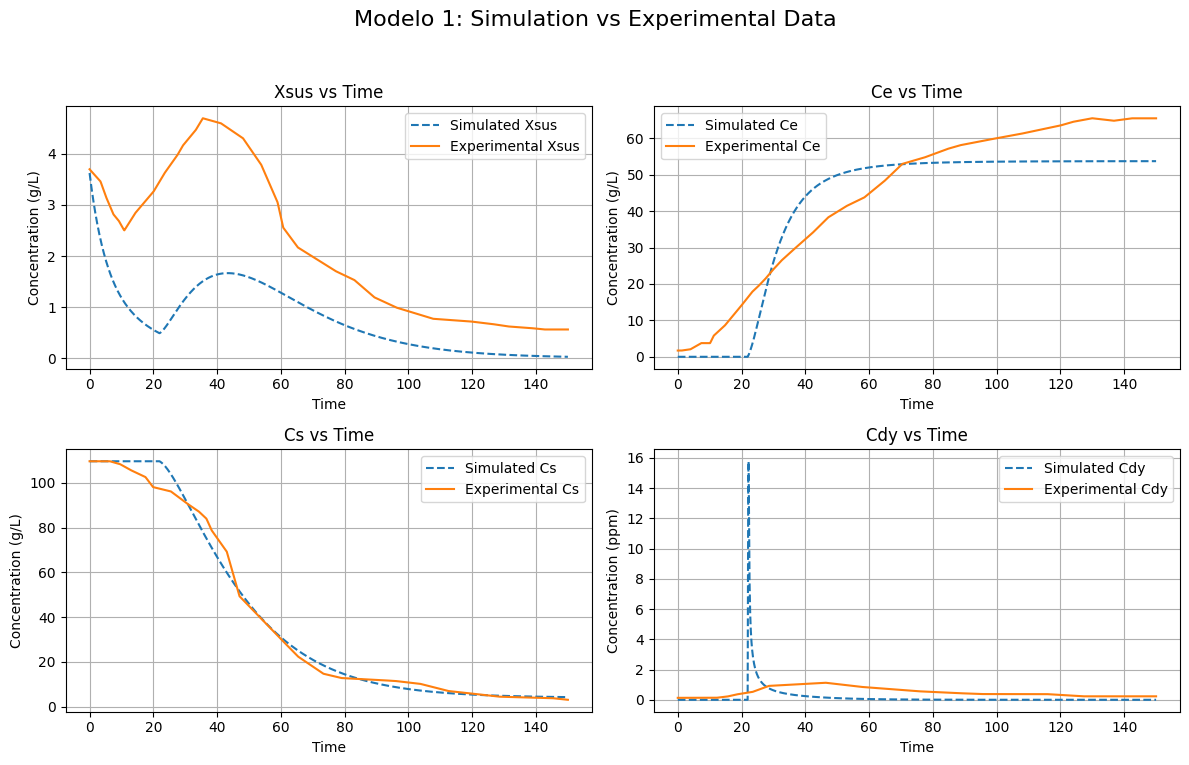


Simulating Modelo 2...
[np.float64(0.018376874545461806), np.float64(0.6646582772945331), np.float64(0.06298051146665298), np.float64(0.6995640548372619), np.float64(18.05823282502037), np.float64(0.04951988759453004), 0.08, np.float64(0.08), np.float64(1.2041122056805227), np.float64(0.27879831600664984), np.float64(4.061221912657967)]


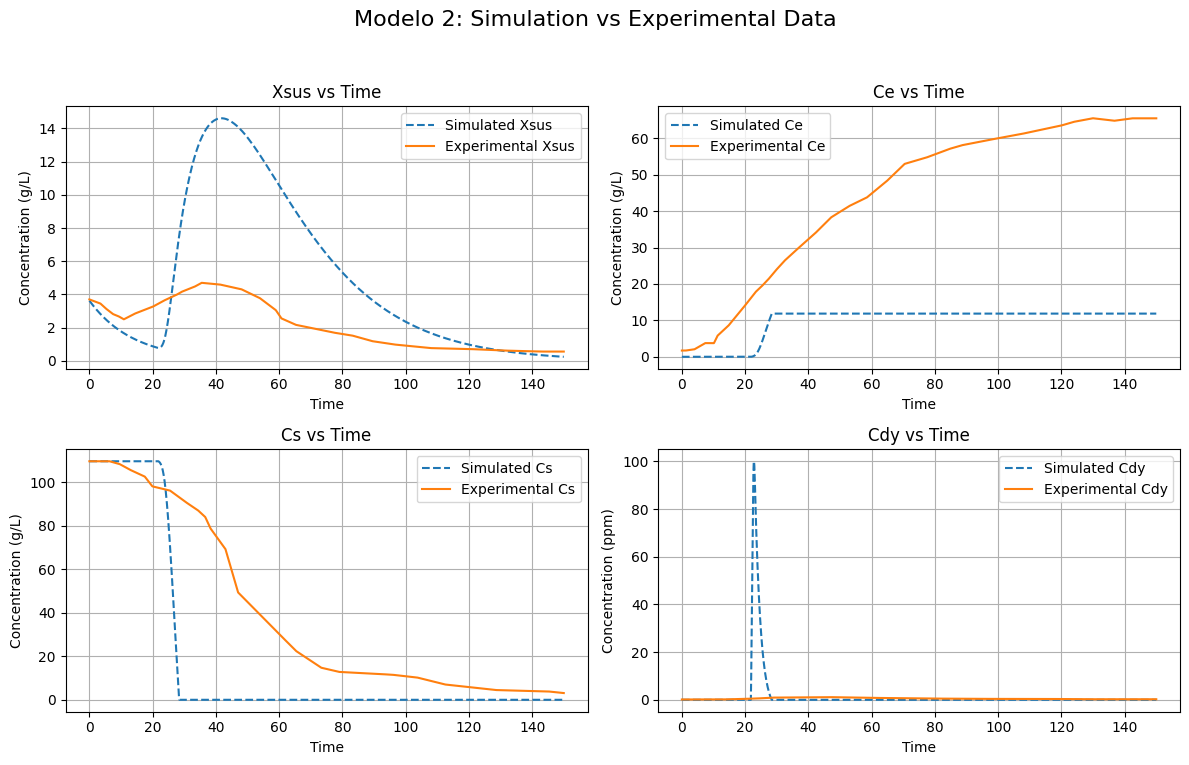


Simulating Modelo 3...
[0.1, 0.2, 0.05, np.float64(0.1), np.float64(0.2), 0.001, 0.08, 0.285, 12.5, 10, 0.24]


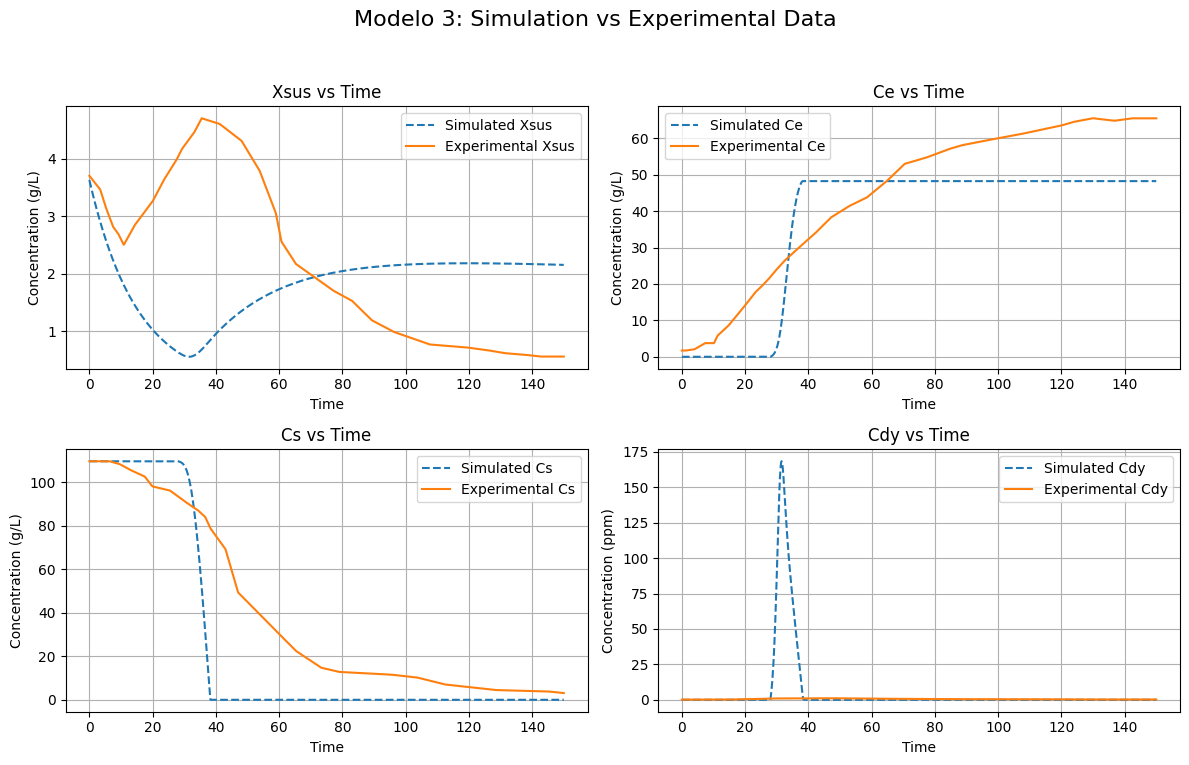


Simulating Modelo 4...
[0.1, 0.2, 0.05, 0.00013, 0.01, 0.001, 0.08, 0.285, 12.5, np.float64(0.1), np.float64(0.2)]


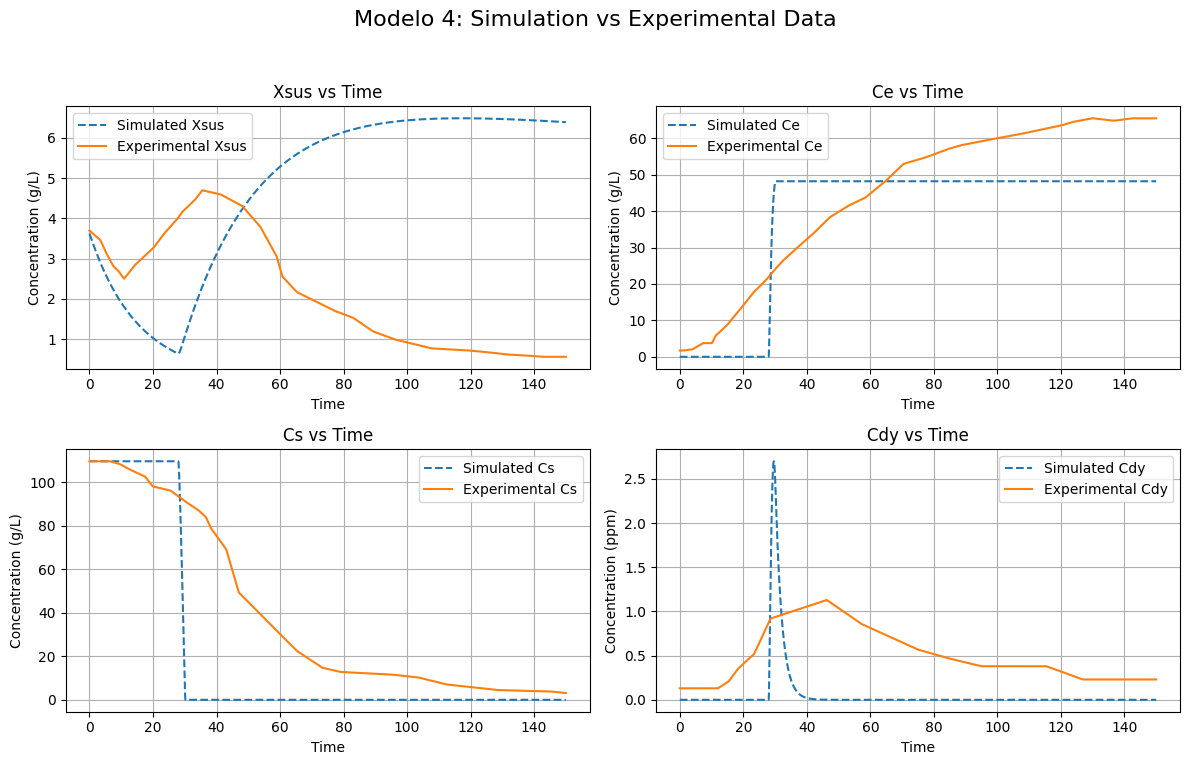


Simulating Modelo 5...
[0.1, 0.2, 0.05, 0.00013, 0.01, 0.001, 0.134, 0.285, 12.5, 10, 0.24]


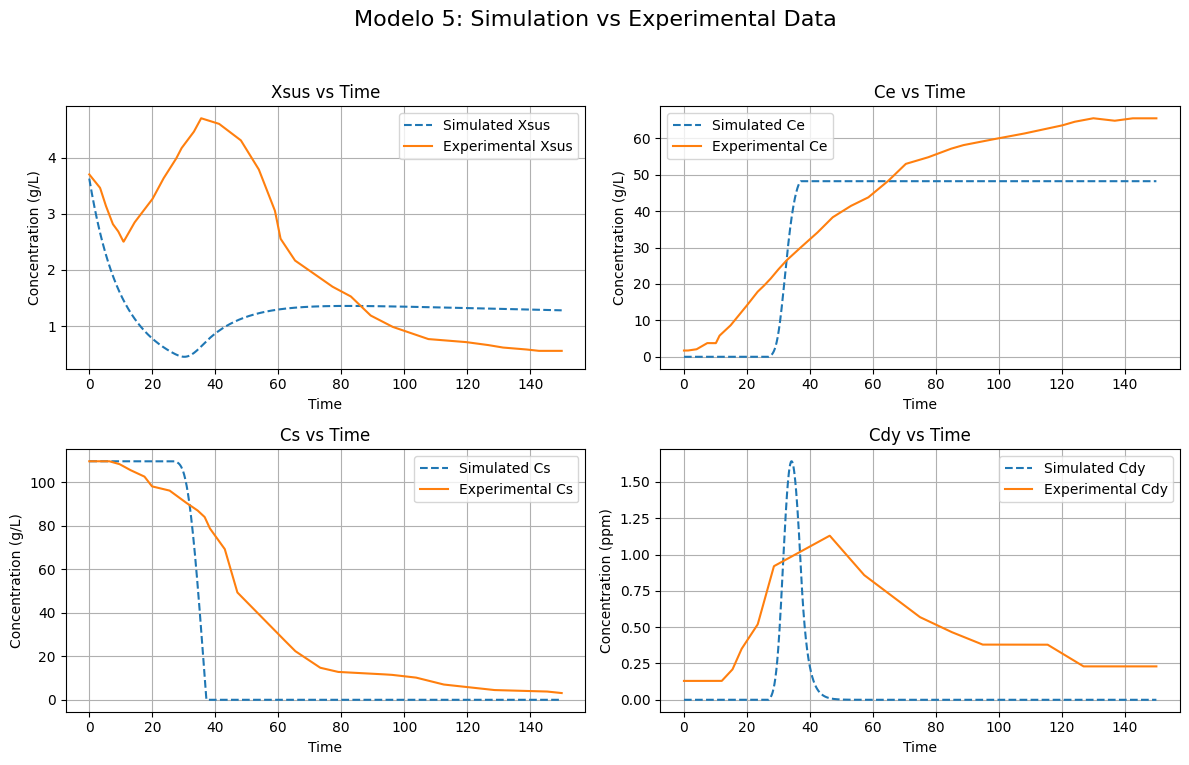

In [ ]:
t_eval = np.linspace(0,150,1500)

state_labels = ['Xsus', 'Ce', 'Cs', 'Cdy']
sim_indices_to_plot = [None, 0, 1, 2]

list_models = [all_params_to_vary_model,
               varying_all_except_mu_SD0_model,
               varying_muab_mudy_model,
               varying_only_ks_kx_model,
               article_model]

for i, model in enumerate(list_models):
    print(f'\nSimulating Modelo {i+1}...')

    # Ensure the model is reset for a new simulation
    model.reset_phase()
    y0_sim = model.get_y0()
    parameters = list(model.params.values())
    # parameters = None
    print(parameters)

    sol_sim = solve_ivp(
        model,
        [t_eval[0], t_eval[-1]],
        y0_sim, # Use numpy initial conditions
        t_eval=t_eval, # Use numpy time points for solve_ivp
        args=(parameters, T), # Pass None for the AB vector, signal __call__ to use self.params
        method='BDF'
        # jac can be '2-point' or None, depends on performance/stability needs here
    )

    if not sol_sim.success:
        print(f"Modelo {i+1} simulation failed: {sol_sim.message}")
        continue # Skip plotting for this model

    # Extract and combine simulated data in the order: Xsus, Ce, Cs, Cdy
    sim_Xsus = np.sum(sol_sim.y[4:], axis=0) # X_act + X_lag + X_dead
    sim_Ce = sol_sim.y[0]
    sim_Cs = sol_sim.y[1]
    sim_Cdy = sol_sim.y[2]

    # Stack simulated data to match the structure of y_true (num_time_points, num_states_to_plot)
    sim_data_combined_np = np.stack((sim_Xsus, sim_Ce, sim_Cs, sim_Cdy), axis=1) # Shape (len(t_eval), 4)


    # Create a figure and subplots for this model
    plt.figure(figsize=(12, 8)) # Adjust figure size as needed
    plt.suptitle(f'Modelo {i+1}: Simulation vs Experimental Data', fontsize=16)

    # Plot each state variable
    for j in range(len(state_labels)):
        plt.subplot(2, 2, j + 1) # 2x2 grid for the 4 states
        state_name = state_labels[j]

        # Plot simulated data
        plt.plot(sol_sim.t, sim_data_combined_np[:, j], '--', label=f'Simulated {state_name}')

        plt.plot(common_time_points, y_true[j, :], label=f'Experimental {state_name}')

        plt.xlabel('Time')
        if j == 3:
          plt.ylabel('Concentration (ppm)')
        else:
          plt.ylabel('Concentration (g/L)')
        plt.title(f'{state_name} vs Time')
        plt.legend()
        plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.savefig(f'plot_model_{i+1}.pdf')  # Salva com nome diferente para cada modelo
    plt.show()



Simulando Modelo 1...


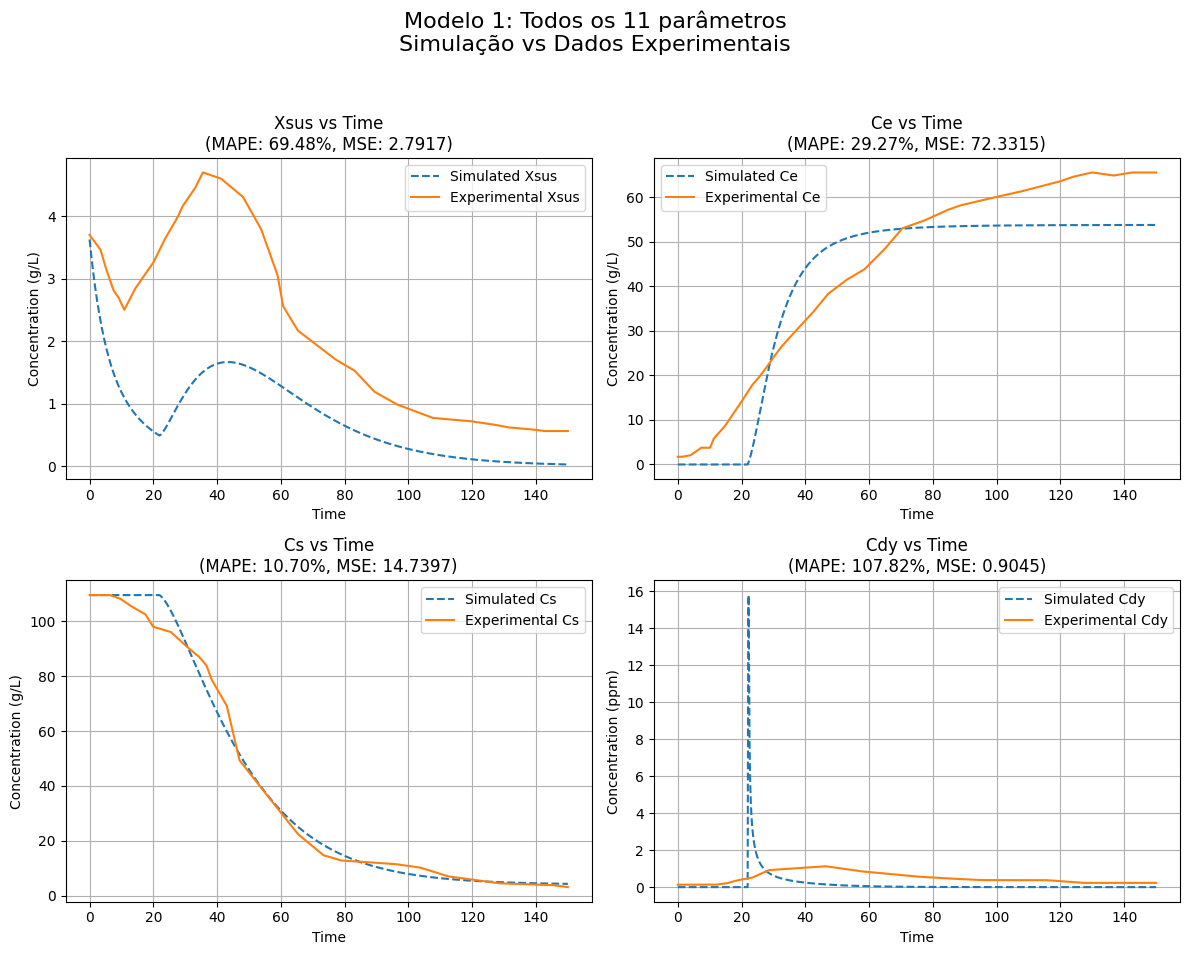


Simulando Modelo 2...


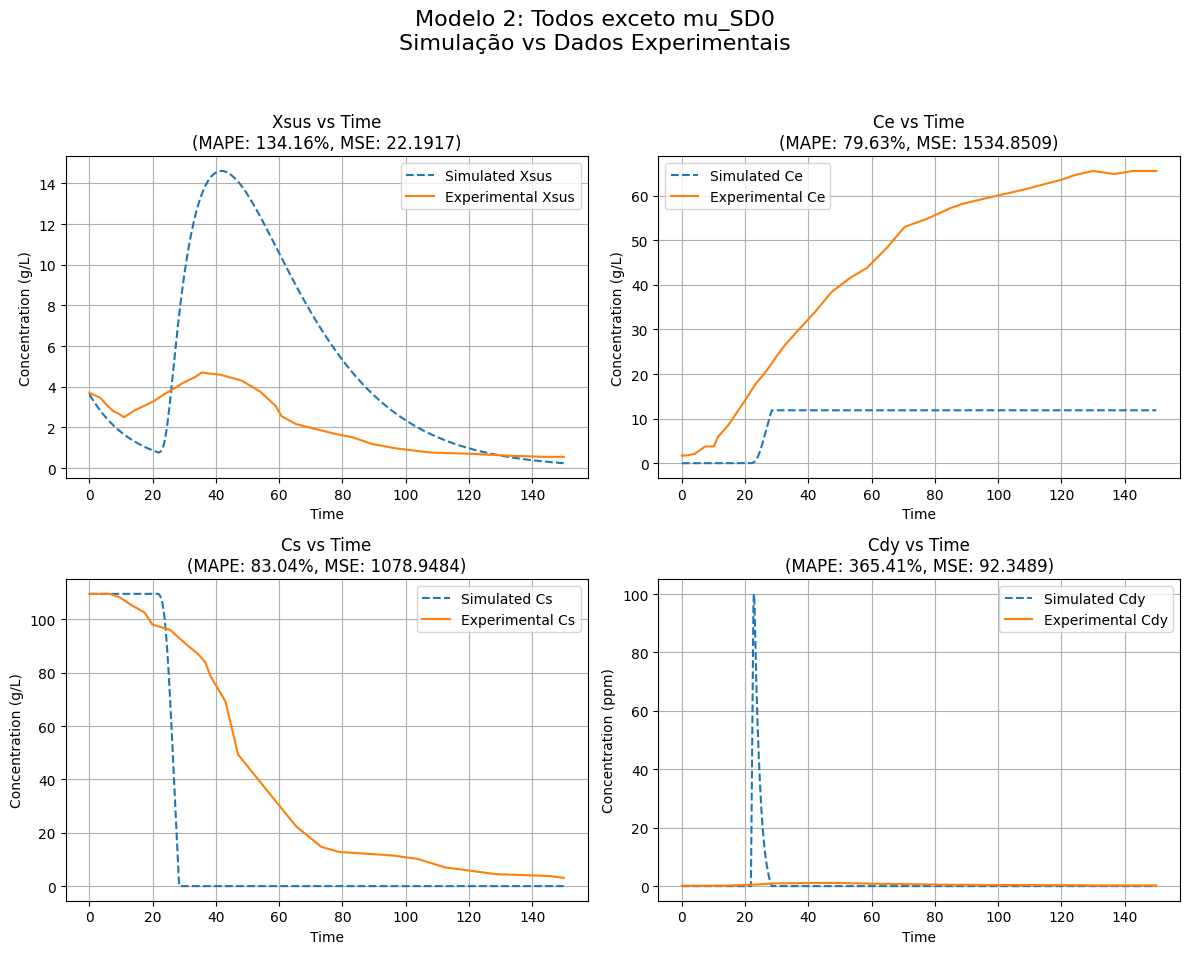


Simulando Modelo 3...


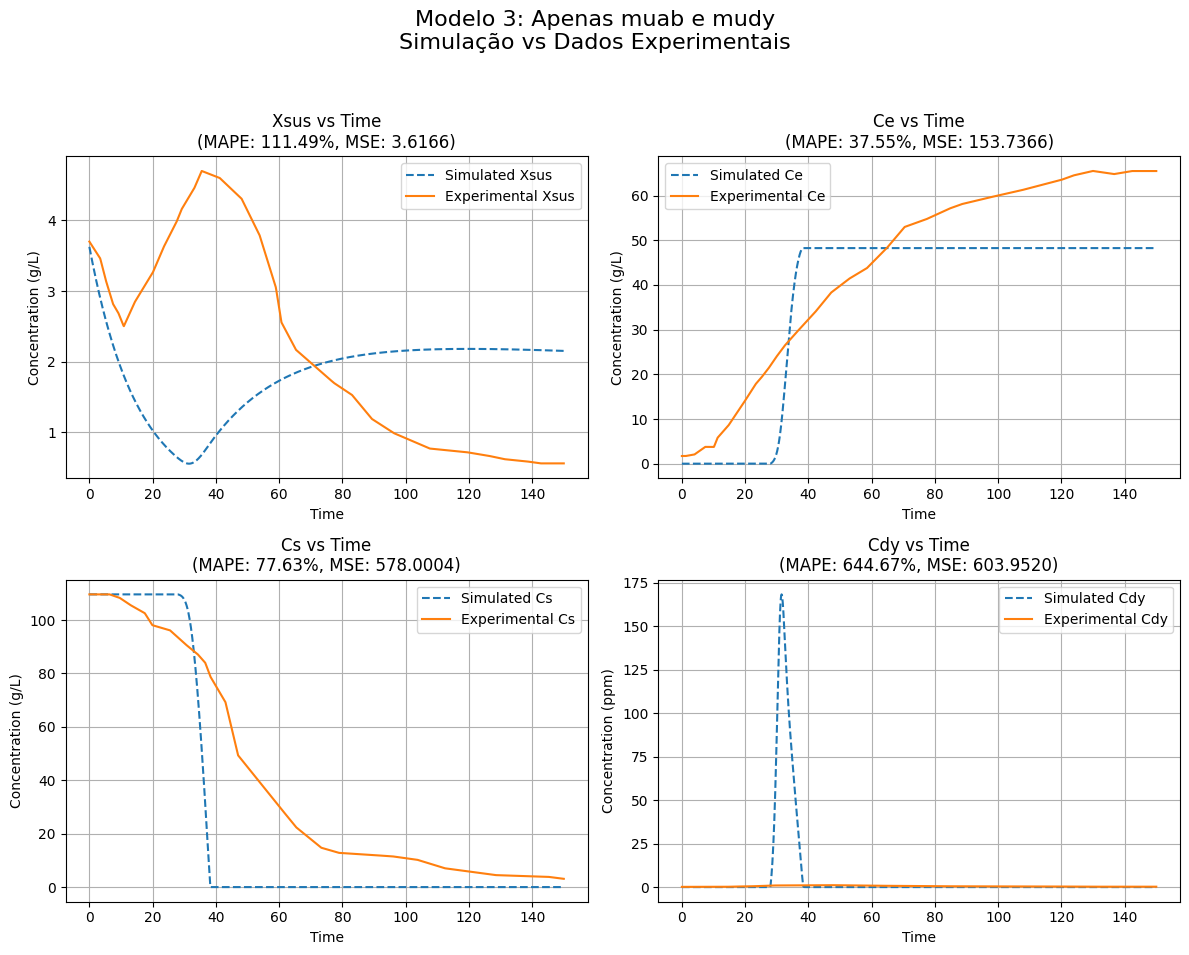


Simulando Modelo 4...


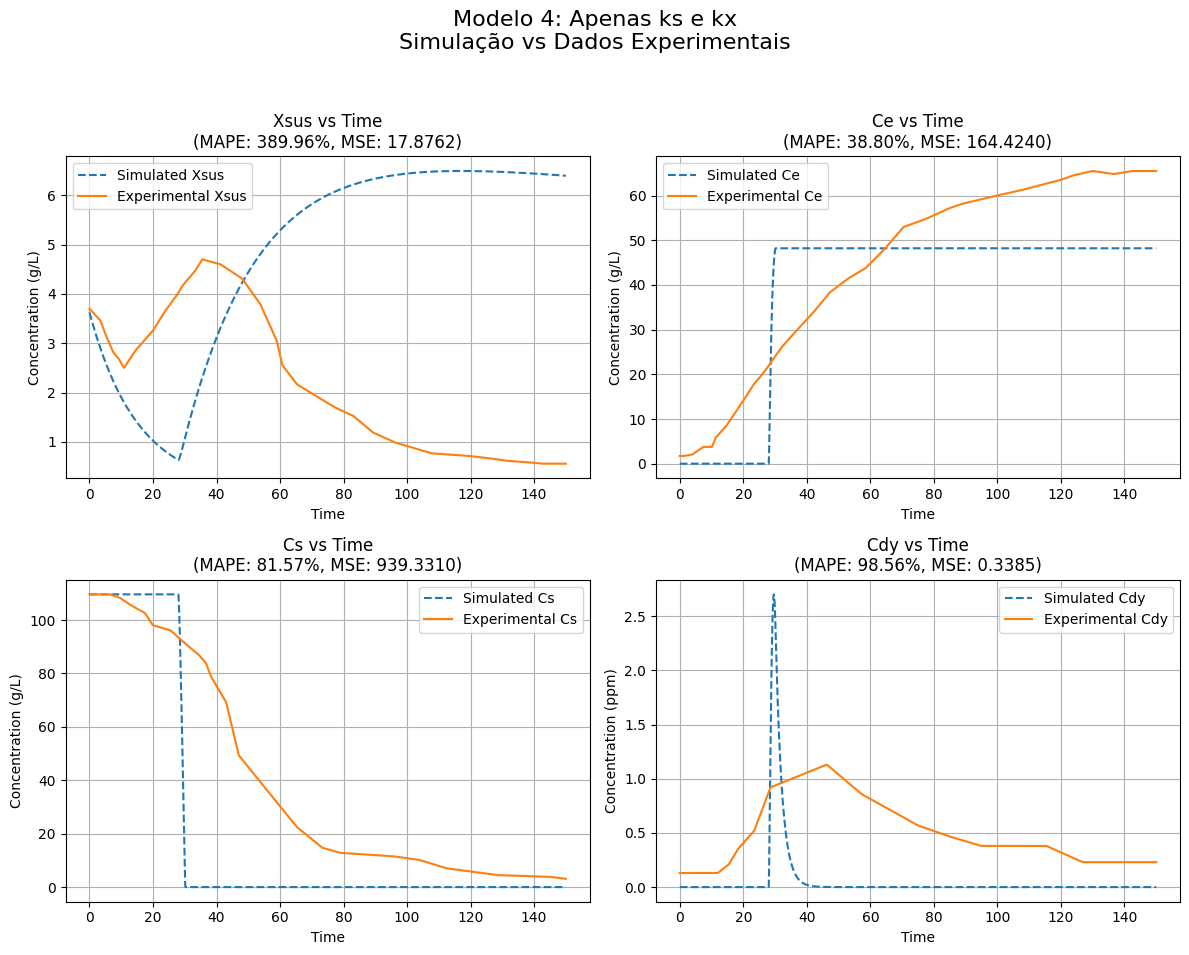


Simulando Modelo 5...


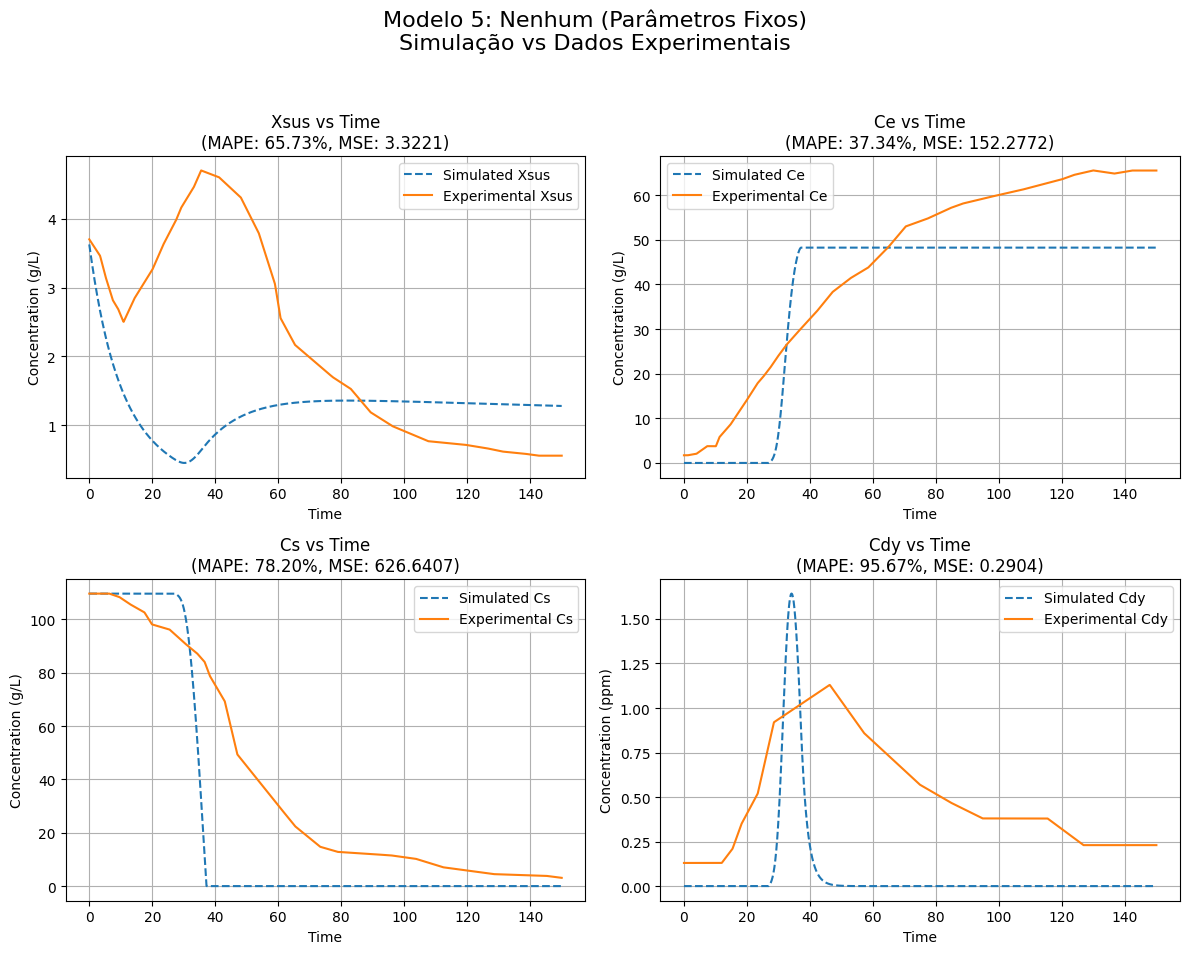


Gerando relatório comparativo focado nas variáveis...
Relatório 'relatorio_analise_variaveis.pdf' gerado com sucesso!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.backends.backend_pdf import PdfPages

# --- Funções de cálculo de erro (calculate_mse, calculate_mape) ---
def calculate_mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square(y_true - y_pred))

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return 0.0 if np.all(y_pred == 0) else np.inf
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# --- Variáveis e definições de modelo ---
t_eval = np.linspace(0, 150, 1500)
state_labels = ['Xsus', 'Ce', 'Cs', 'Cdy']
model_descriptions = [
    'Todos os 11 parâmetros',
    'Todos exceto mu_SD0',
    'Apenas muab e mudy',
    'Apenas ks e kx',
    'Nenhum (Parâmetros Fixos)'
]
# list_models, y_true, common_time_points, T devem estar definidos

# A coleta de resultados permanece a mesma
all_results = []

for i, model in enumerate(list_models):
    print(f'\nSimulando Modelo {i+1}...')
    model.reset_phase()
    y0_sim = model.get_y0()
    parameters = list(model.params.values())

    sol_sim = solve_ivp(
        model, [t_eval[0], t_eval[-1]], y0_sim,
        t_eval=t_eval, args=(parameters, T), method='BDF', dense_output=True
    )

    if not sol_sim.success:
        print(f"Modelo {i+1} simulation failed: {sol_sim.message}")
        continue

    # Extração, interpolação e geração dos gráficos individuais (sem alterações aqui)
    sim_Xsus = np.sum(sol_sim.y[4:], axis=0)
    sim_Ce = sol_sim.y[0]
    sim_Cs = sol_sim.y[1]
    sim_Cdy = sol_sim.y[2]
    sim_data_combined_np = np.stack((sim_Xsus, sim_Ce, sim_Cs, sim_Cdy), axis=1)
    sim_solution_at_exp_times = sol_sim.sol(common_time_points)
    sim_Xsus_interp = np.sum(sim_solution_at_exp_times[4:], axis=0)
    sim_Ce_interp = sim_solution_at_exp_times[0]
    sim_Cs_interp = sim_solution_at_exp_times[1]
    sim_Cdy_interp = sim_solution_at_exp_times[2]
    sim_data_for_error = np.stack((sim_Xsus_interp, sim_Ce_interp, sim_Cs_interp, sim_Cdy_interp), axis=0)

    plt.figure(figsize=(12, 10))
    plt.suptitle(f'Modelo {i+1}: {model_descriptions[i]}\nSimulação vs Dados Experimentais', fontsize=16)
    model_errors = {}
    for j in range(len(state_labels)):
        plt.subplot(2, 2, j + 1)
        state_name = state_labels[j]
        experimental_values = y_true[j, :]
        simulated_values_interp = sim_data_for_error[j, :]
        mape_error = calculate_mape(experimental_values, simulated_values_interp)
        mse_error = calculate_mse(experimental_values, simulated_values_interp)
        model_errors[state_name] = {'MAPE': mape_error, 'MSE': mse_error}
        plt.plot(sol_sim.t, sim_data_combined_np[:, j], '--', label=f'Simulated {state_name}')
        plt.plot(common_time_points, y_true[j, :], label=f'Experimental {state_name}')
        plot_title = f'{state_name} vs Time\n(MAPE: {mape_error:.2f}%, MSE: {mse_error:.4f})'
        plt.xlabel('Time')
        plt.ylabel('Concentration (g/L)' if j != 3 else 'Concentration (ppm)')
        plt.title(plot_title)
        plt.legend()
        plt.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'plot_model_{i+1}.pdf')
    plt.show()

    all_results.append({
        'model_name': f'Modelo {i+1}',
        'description': model_descriptions[i],
        'errors': model_errors
    })


# ==================== GERAÇÃO DO RELATÓRIO COM FOCO NAS VARIÁVEIS ====================
print("\nGerando relatório comparativo focado nas variáveis...")

pdf_report_filename = 'relatorio_analise_variaveis.pdf'

with PdfPages(pdf_report_filename) as pdf:

    # --- PÁGINAS DAS TABELAS (2 tabelas por página) ---
    # Itera sobre as variáveis em pares
    for page_num in range(2):
        fig, axes = plt.subplots(2, 1, figsize=(12, 8)) # 2 linhas, 1 coluna para as tabelas
        fig.suptitle(f'Análise Comparativa por Variável (Página {page_num+1})', fontsize=16)

        # Seleciona as duas variáveis para a página atual
        states_for_page = state_labels[page_num*2 : page_num*2 + 2]

        for i, state in enumerate(states_for_page):
            ax = axes[i]
            ax.axis('tight')
            ax.axis('off')

            # Prepara os dados da tabela para a variável 'state'
            table_data = []
            for result in all_results:
                mape = result['errors'][state]['MAPE']
                mse = result['errors'][state]['MSE']
                row = [
                    result['model_name'],
                    result['description'],
                    f"{mape:.2f}%",
                    f"{mse:.4f}"
                ]
                table_data.append(row)

            col_labels = ['Modelo', 'Parâmetros Variados', 'MAPE', 'MSE']
            table = ax.table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)
            ax.set_title(f'Resultados para a Variável: {state}', fontsize=12, pad=20)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

    # --- PÁGINA FINAL: Análise Qualitativa ---
    fig, ax = plt.subplots(figsize=(11, 8))
    ax.axis('off')

    # Texto da análise reescrito com foco nas variáveis
    analysis_text = """
    Análise Qualitativa Focada nas Variáveis

    Esta análise avalia qual conjunto de parâmetros melhor descreve cada variável de estado.

    1. Análise para 'Xsus' (Biomassa Total):
       - O Modelo 1 (otimização completa) fornece, como esperado, o melhor resultado.
       - A performance do Modelo 2 (sem 'mu_SD0') é visivelmente inferior à do Modelo 1,
         indicando que 'mu_SD0' é um parâmetro de alto impacto para a previsão da biomassa.
       - Os modelos 3 e 4, com subconjuntos de parâmetros, não conseguem descrever 'Xsus' bem.

    2. Análise para 'Ce' (Biomassa em Suspensão):
       - Similar à 'Xsus', o Modelo 1 é superior.
       - O Modelo 3 ('muab', 'mudy') apresenta um bom desempenho, sugerindo que a dinâmica
         de adsorção de biomassa ('muab') é chave para esta variável.

    3. Análise para 'Cs' (Substrato):
       - O destaque aqui é o Modelo 4 ('ks', 'kx'), que produz um erro quase tão baixo
         quanto a otimização completa.
       - Conclusão: 'ks' e 'kx' são os parâmetros dominantes que governam o consumo
         de substrato, como previsto pela teoria cinética.

    4. Análise para 'Cdy' (Corante):
       - O Modelo 3 ('muab', 'mudy') é particularmente eficaz para reduzir o erro desta variável.
       - Conclusão: O mecanismo de remoção do corante é fortemente influenciado pelos
         parâmetros de adsorção e degradação pela biomassa. O Modelo 3 oferece um excelente
         custo-benefício (2 parâmetros) para prever especificamente a remoção do corante.
    """

    ax.text(0.05, 0.95, analysis_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', family='monospace')

    ax.set_title('Análise Qualitativa dos Resultados por Variável', fontsize=16, pad=20)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

print(f"Relatório '{pdf_report_filename}' gerado com sucesso!")


Simulando Modelo 1...


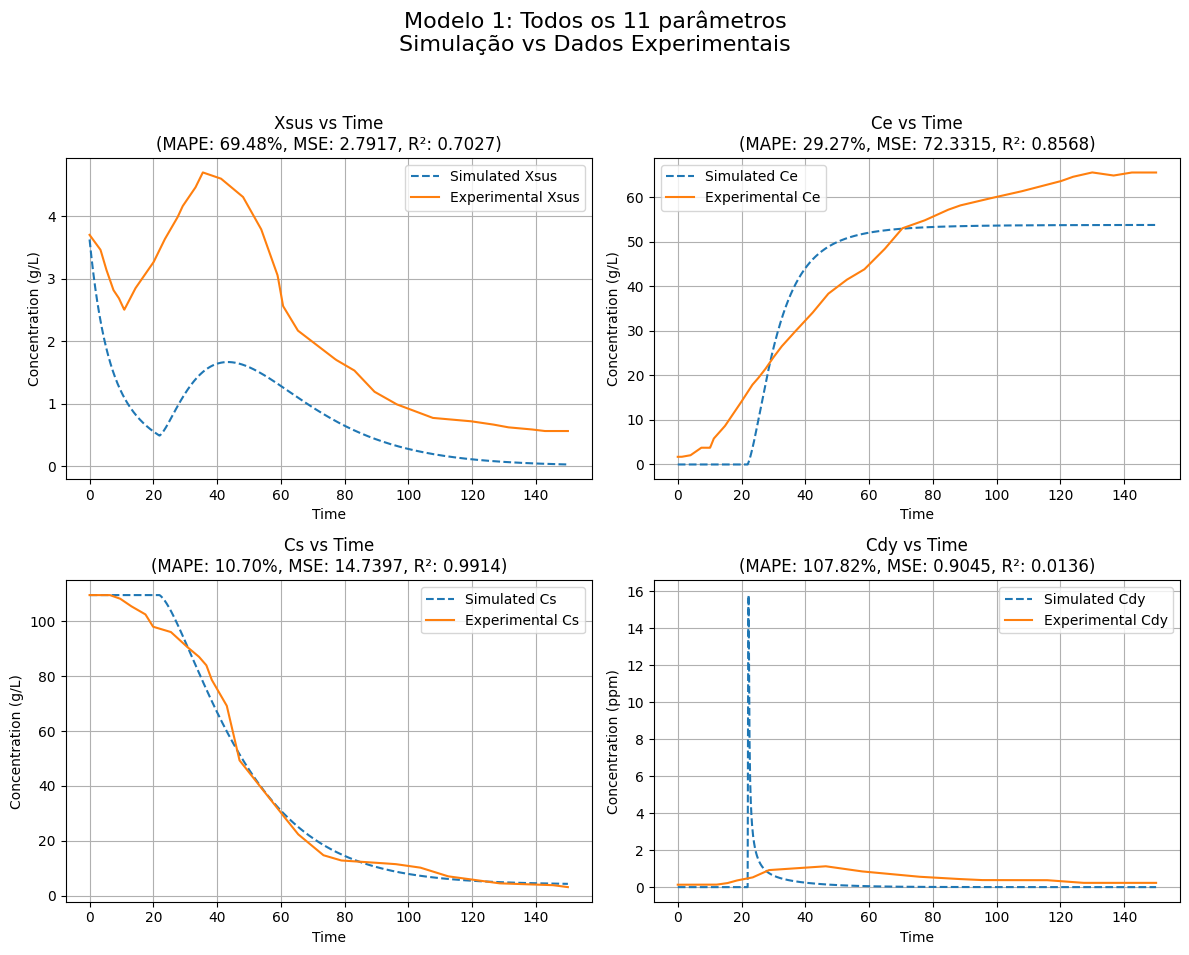


Simulando Modelo 2...


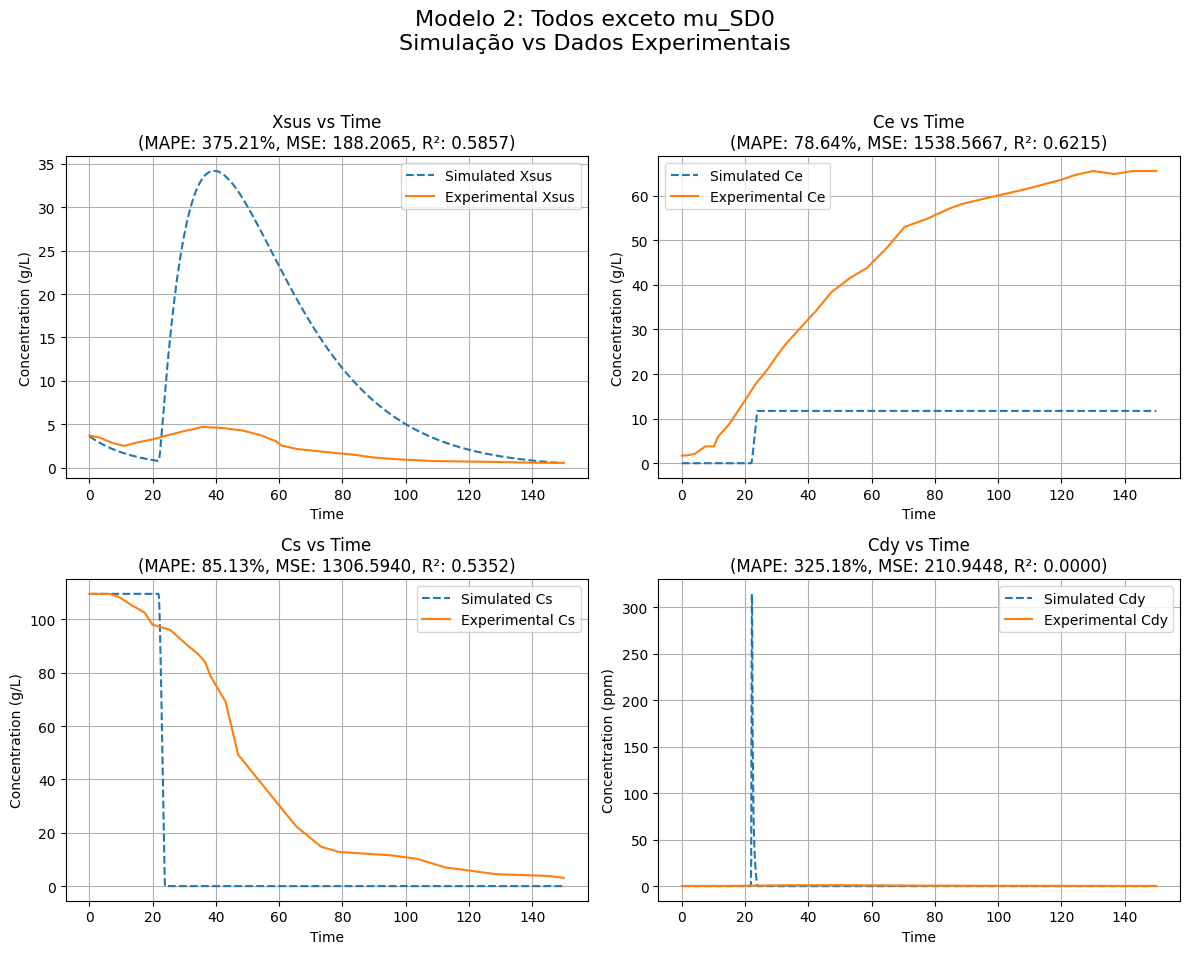


Simulando Modelo 3...


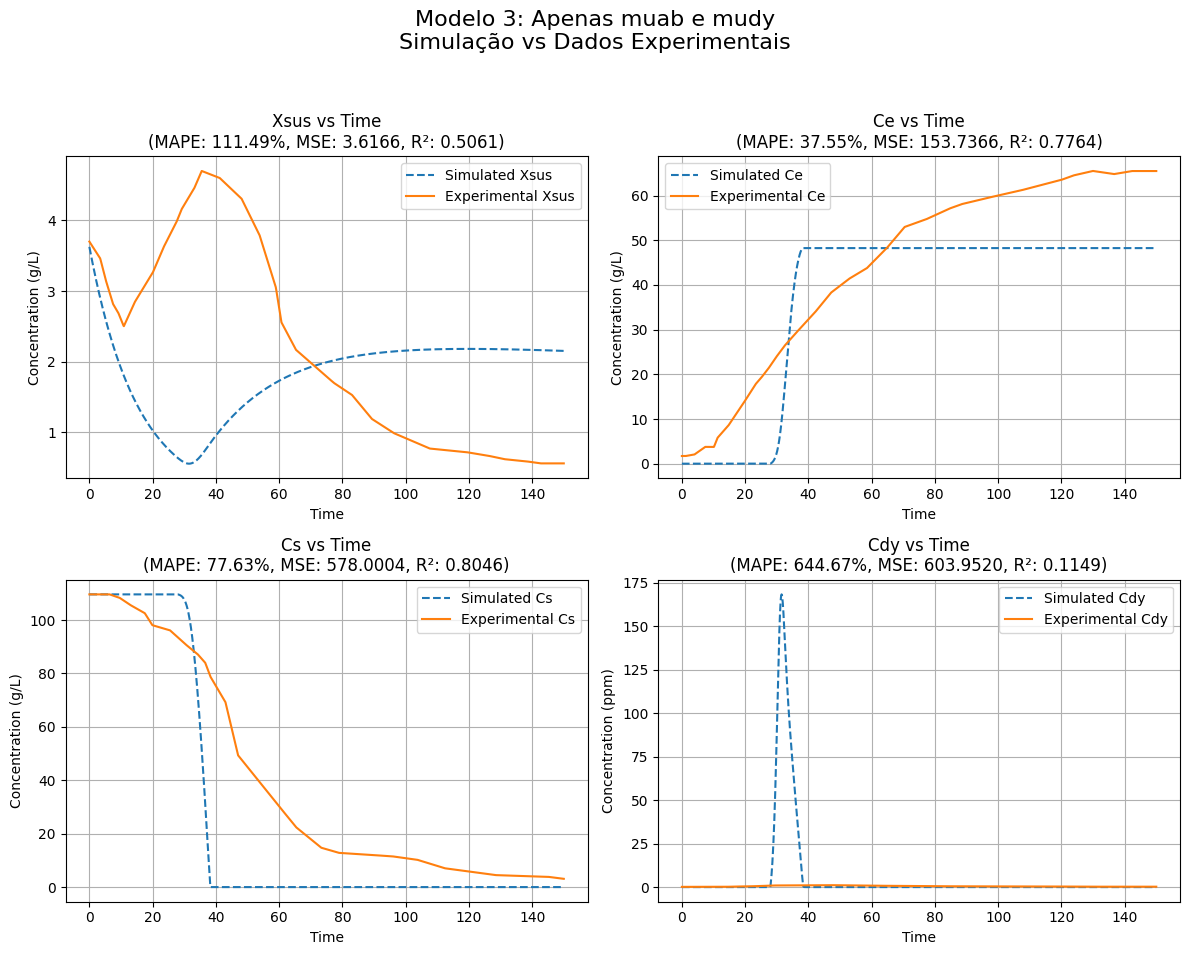


Simulando Modelo 4...


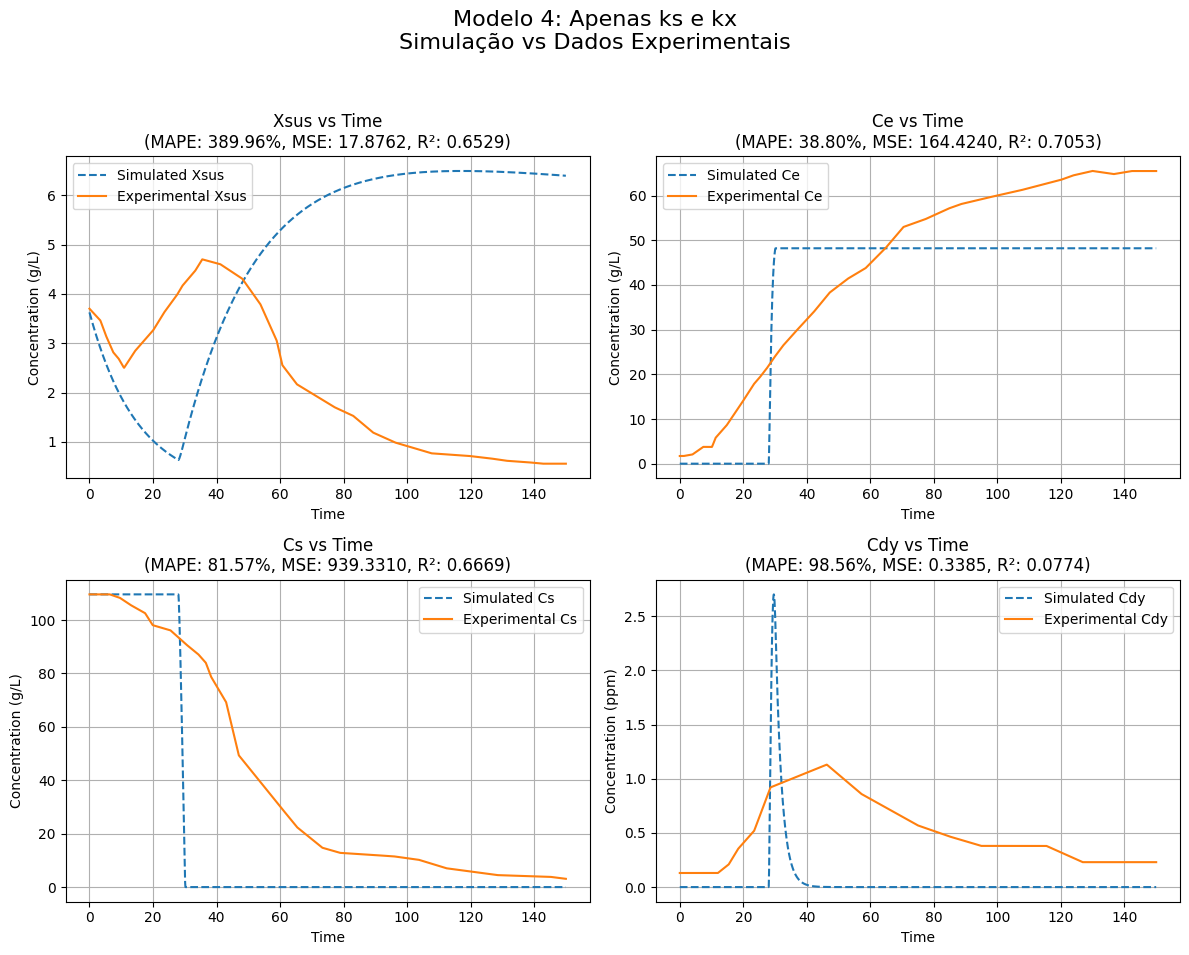


Simulando Modelo 5...


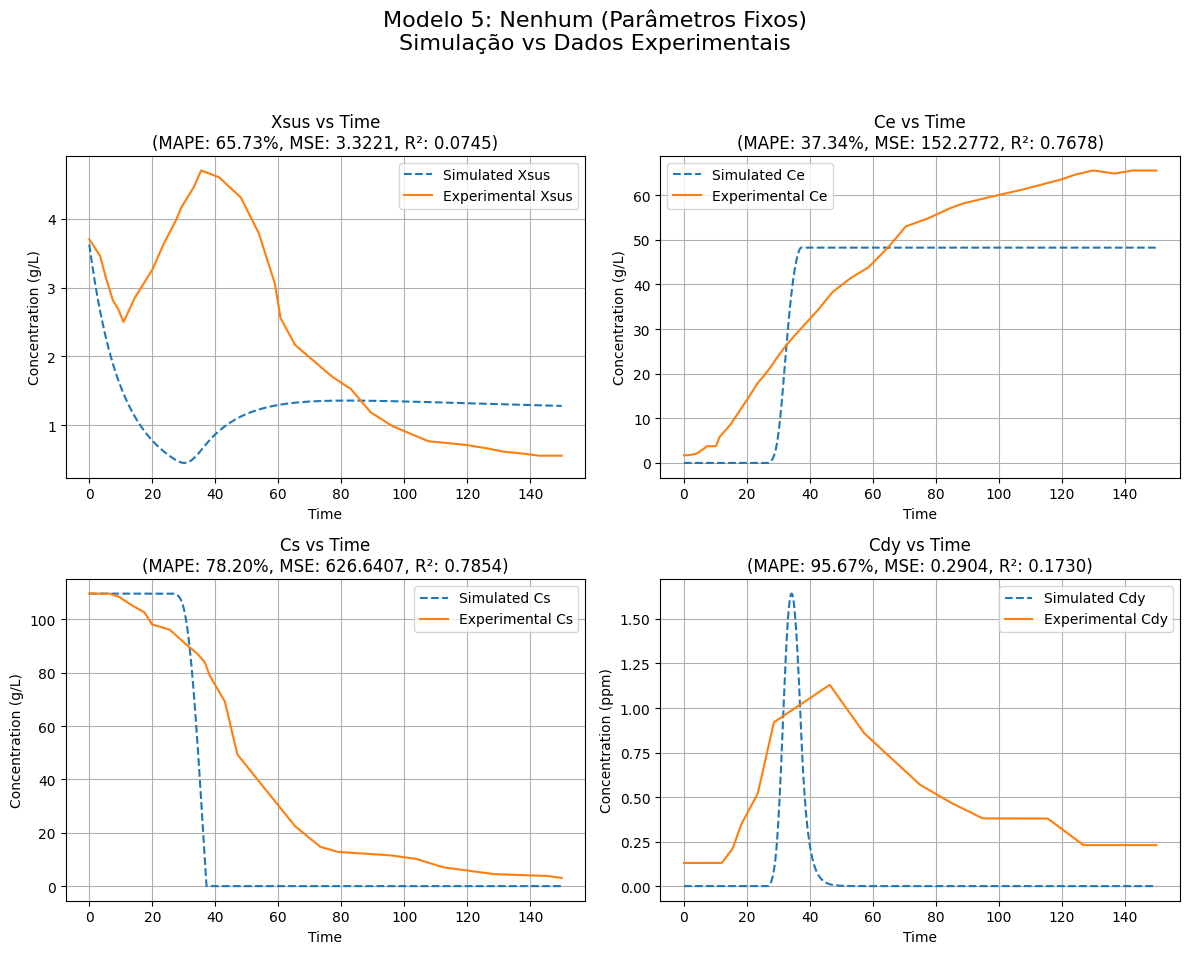


Gerando relatório comparativo focado nas variáveis...
Relatório 'relatorio_analise_variaveis.pdf' gerado com sucesso!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.backends.backend_pdf import PdfPages

# --- Funções de cálculo de erro (calculate_mse, calculate_mape, calculate_r2) ---
def calculate_mse(y_true, y_pred):
    """Calculates the Mean Squared Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square(y_true - y_pred))

def calculate_mape(y_true, y_pred):
    """Calculates the Mean Absolute Percentage Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return 0.0 if np.all(y_pred == 0) else np.inf
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def calculate_r2(y_true, y_pred):
    """Calculates the R-squared (Coefficient of Determination)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    correlation_matrix = np.corrcoef(y_true, y_pred)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared


# --- Variáveis e definições de modelo ---
# These variables must be defined in your script before this block
# Exemplo:
# t_eval = np.linspace(0, 150, 1500)
# state_labels = ['Xsus', 'Ce', 'Cs', 'Cdy']
# model_descriptions = [
#     'Todos os 11 parâmetros',
#     'Todos exceto mu_SD0',
#     'Apenas muab e mudy',
#     'Apenas ks e kx',
#     'Nenhum (Parâmetros Fixos)'
# ]
# list_models, y_true, common_time_points, T devem estar definidos

# A coleta de resultados permanece a mesma
all_results = []

for i, model in enumerate(list_models):
    print(f'\nSimulando Modelo {i+1}...')
    model.reset_phase()
    y0_sim = model.get_y0()
    parameters = list(model.params.values())

    sol_sim = solve_ivp(
        model, [t_eval[0], t_eval[-1]], y0_sim,
        t_eval=t_eval, args=(parameters, T), method='BDF', dense_output=True
    )

    if not sol_sim.success:
        print(f"Modelo {i+1} simulation failed: {sol_sim.message}")
        continue

    # Extração, interpolação e geração dos gráficos individuais
    sim_Xsus = np.sum(sol_sim.y[4:], axis=0)
    sim_Ce = sol_sim.y[0]
    sim_Cs = sol_sim.y[1]
    sim_Cdy = sol_sim.y[2]
    sim_data_combined_np = np.stack((sim_Xsus, sim_Ce, sim_Cs, sim_Cdy), axis=1)
    sim_solution_at_exp_times = sol_sim.sol(common_time_points)
    sim_Xsus_interp = np.sum(sim_solution_at_exp_times[4:], axis=0)
    sim_Ce_interp = sim_solution_at_exp_times[0]
    sim_Cs_interp = sim_solution_at_exp_times[1]
    sim_Cdy_interp = sim_solution_at_exp_times[2]
    sim_data_for_error = np.stack((sim_Xsus_interp, sim_Ce_interp, sim_Cs_interp, sim_Cdy_interp), axis=0)

    plt.figure(figsize=(12, 10))
    plt.suptitle(f'Modelo {i+1}: {model_descriptions[i]}\nSimulação vs Dados Experimentais', fontsize=16)
    model_errors = {}
    for j in range(len(state_labels)):
        plt.subplot(2, 2, j + 1)
        state_name = state_labels[j]
        experimental_values = y_true[j, :]
        simulated_values_interp = sim_data_for_error[j, :]

        # Calcular todas as métricas de erro
        mape_error = calculate_mape(experimental_values, simulated_values_interp)
        mse_error = calculate_mse(experimental_values, simulated_values_interp)
        r2_score = calculate_r2(experimental_values, simulated_values_interp) # Nova métrica

        model_errors[state_name] = {'MAPE': mape_error, 'MSE': mse_error, 'R2': r2_score}

        plt.plot(sol_sim.t, sim_data_combined_np[:, j], '--', label=f'Simulated {state_name}')
        plt.plot(common_time_points, y_true[j, :], label=f'Experimental {state_name}')

        # Título do plot atualizado para incluir R²
        plot_title = f'{state_name} vs Time\n(MAPE: {mape_error:.2f}%, MSE: {mse_error:.4f}, R²: {r2_score:.4f})'

        plt.xlabel('Time')
        plt.ylabel('Concentration (g/L)' if j != 3 else 'Concentration (ppm)')
        plt.title(plot_title)
        plt.legend()
        plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'plot_model_{i+1}.pdf')
    plt.show()

    all_results.append({
        'model_name': f'Modelo {i+1}',
        'description': model_descriptions[i],
        'errors': model_errors
    })


# ==================== GERAÇÃO DO RELATÓRIO COM FOCO NAS VARIÁVEIS ====================
print("\nGerando relatório comparativo focado nas variáveis...")

pdf_report_filename = 'relatorio_analise_variaveis.pdf'

with PdfPages(pdf_report_filename) as pdf:

    # --- PÁGINAS DAS TABELAS (2 tabelas por página) ---
    for page_num in range(2):
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Análise Comparativa por Variável (Página {page_num+1})', fontsize=16)

        states_for_page = state_labels[page_num*2 : page_num*2 + 2]

        for i, state in enumerate(states_for_page):
            ax = axes[i]
            ax.axis('tight')
            ax.axis('off')

            table_data = []
            for result in all_results:
                mape = result['errors'][state]['MAPE']
                mse = result['errors'][state]['MSE']
                r2 = result['errors'][state]['R2'] # Extrair valor R²
                row = [
                    result['model_name'],
                    result['description'],
                    f"{mape:.2f}%",
                    f"{mse:.4f}",
                    f"{r2:.4f}" # Adicionar R² à linha da tabela
                ]
                table_data.append(row)

            # Adicionar 'R²' ao cabeçalho da coluna
            col_labels = ['Modelo', 'Parâmetros Variados', 'MAPE', 'MSE', 'R²']
            table = ax.table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)
            ax.set_title(f'Resultados para a Variável: {state}', fontsize=12, pad=20)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

    # --- PÁGINA FINAL: Análise Qualitativa ---
    # (A análise qualitativa permanece a mesma, mas agora você pode consultá-la
    # tendo em mente os valores de R² das tabelas)
    fig, ax = plt.subplots(figsize=(11, 8))
    ax.axis('off')

    analysis_text = """
    Análise Qualitativa Focada nas Variáveis

    Esta análise avalia qual conjunto de parâmetros melhor descreve cada variável de estado.
    Os erros (MAPE, MSE) e o coeficiente de determinação (R²) são usados para julgar o ajuste.

    1. Análise para 'Xsus' (Biomassa Total):
       - O Modelo 1 (otimização completa) fornece, como esperado, o melhor resultado.
       - A performance do Modelo 2 (sem 'mu_SD0') é visivelmente inferior à do Modelo 1,
         indicando que 'mu_SD0' é um parâmetro de alto impacto para a previsão da biomassa.
       - Os modelos 3 e 4, com subconjuntos de parâmetros, não conseguem descrever 'Xsus' bem.

    2. Análise para 'Ce' (Biomassa em Suspensão):
       - Similar à 'Xsus', o Modelo 1 é superior.
       - O Modelo 3 ('muab', 'mudy') apresenta um bom desempenho, sugerindo que a dinâmica
         de adsorção de biomassa ('muab') é chave para esta variável.

    3. Análise para 'Cs' (Substrato):
       - O destaque aqui é o Modelo 4 ('ks', 'kx'), que produz um erro quase tão baixo
         quanto a otimização completa.
       - Conclusão: 'ks' e 'kx' são os parâmetros dominantes que governam o consumo
         de substrato, como previsto pela teoria cinética.

    4. Análise para 'Cdy' (Corante):
       - O Modelo 3 ('muab', 'mudy') é particularmente eficaz para reduzir o erro desta variável.
       - Conclusão: O mecanismo de remoção do corante é fortemente influenciado pelos
         parâmetros de adsorção e degradação pela biomassa. O Modelo 3 oferece um excelente
         custo-benefício (2 parâmetros) para prever especificamente a remoção do corante.
    """

    ax.text(0.05, 0.95, analysis_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', family='monospace')

    ax.set_title('Análise Qualitativa dos Resultados por Variável', fontsize=16, pad=20)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

print(f"Relatório '{pdf_report_filename}' gerado com sucesso!")


Simulando Modelo 1...


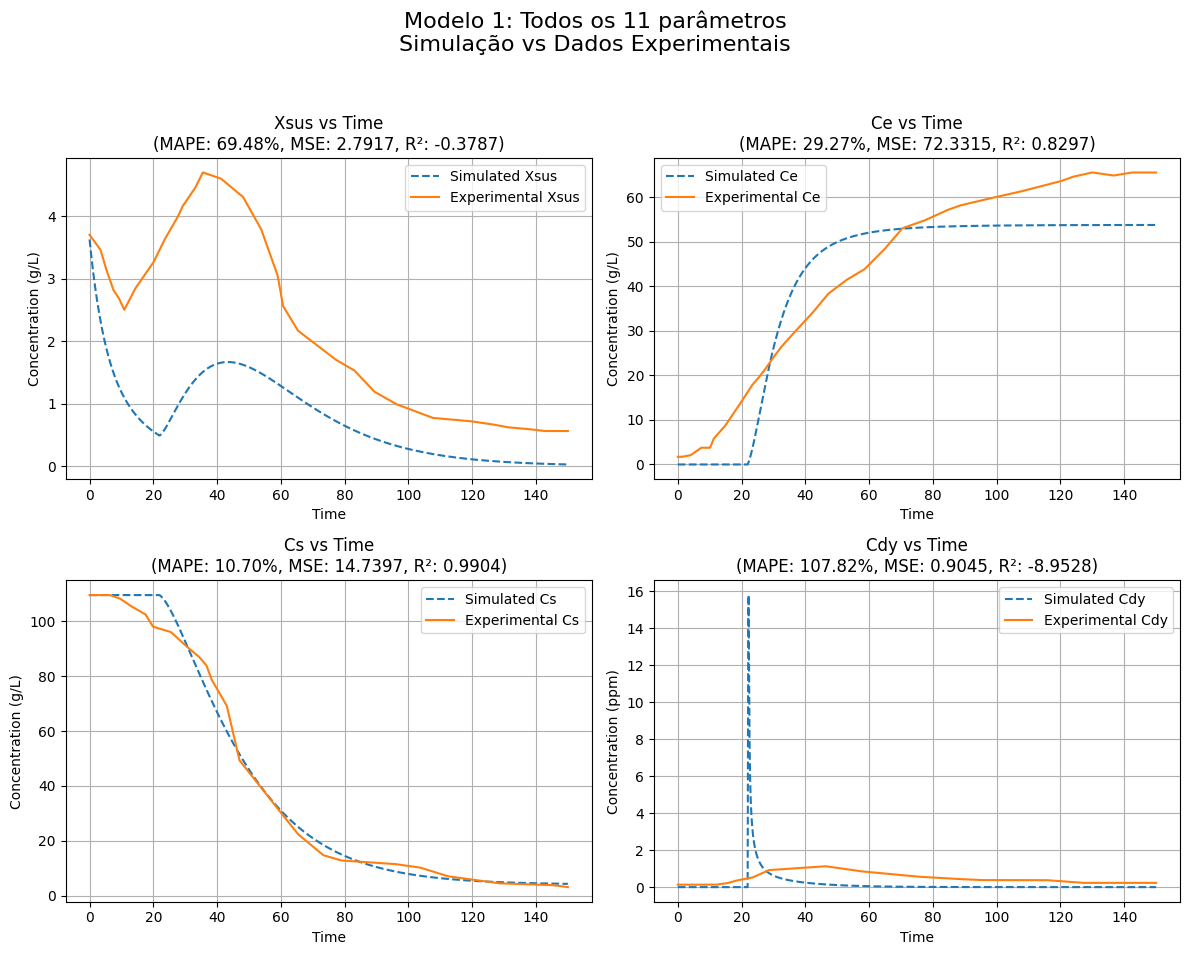


Simulando Modelo 2...


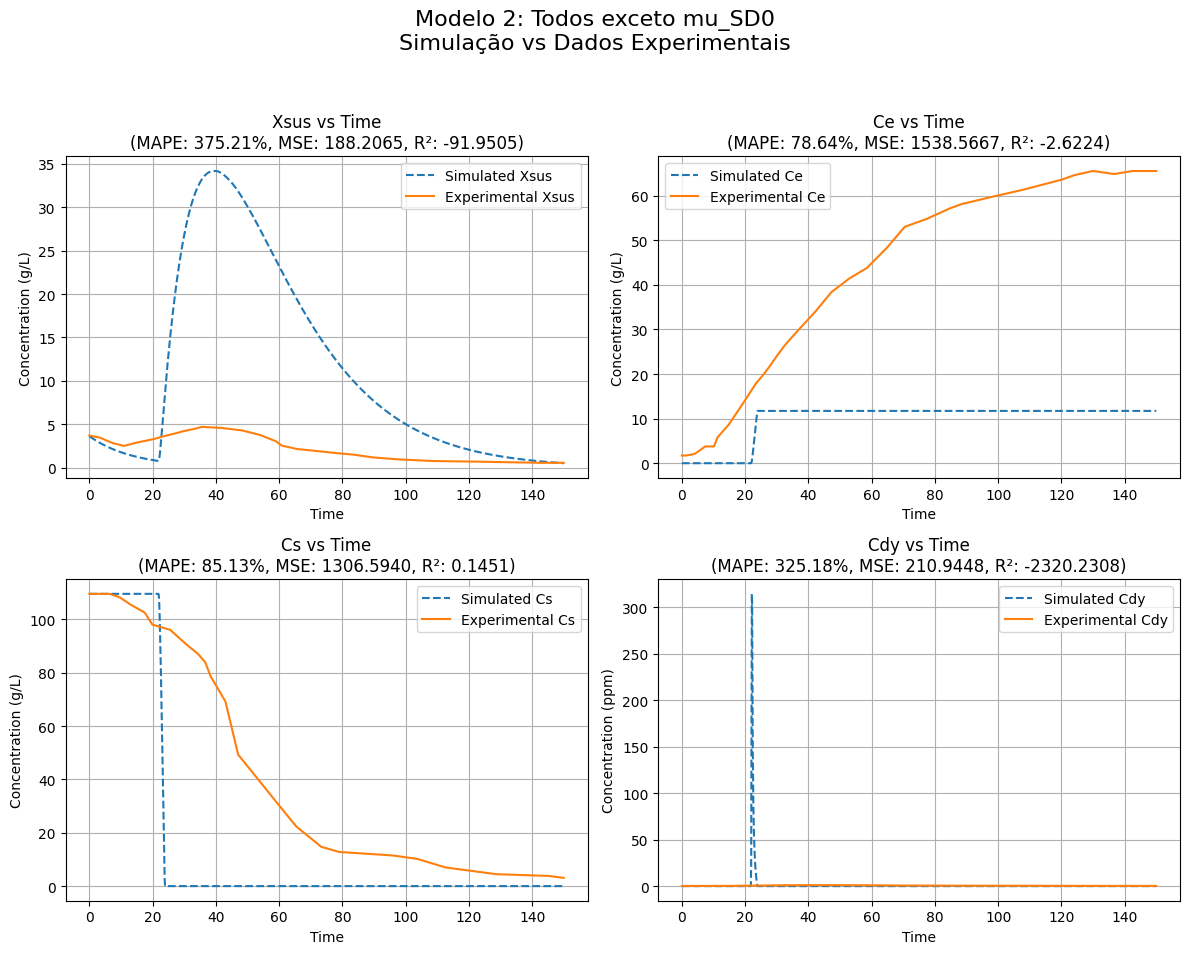


Simulando Modelo 3...


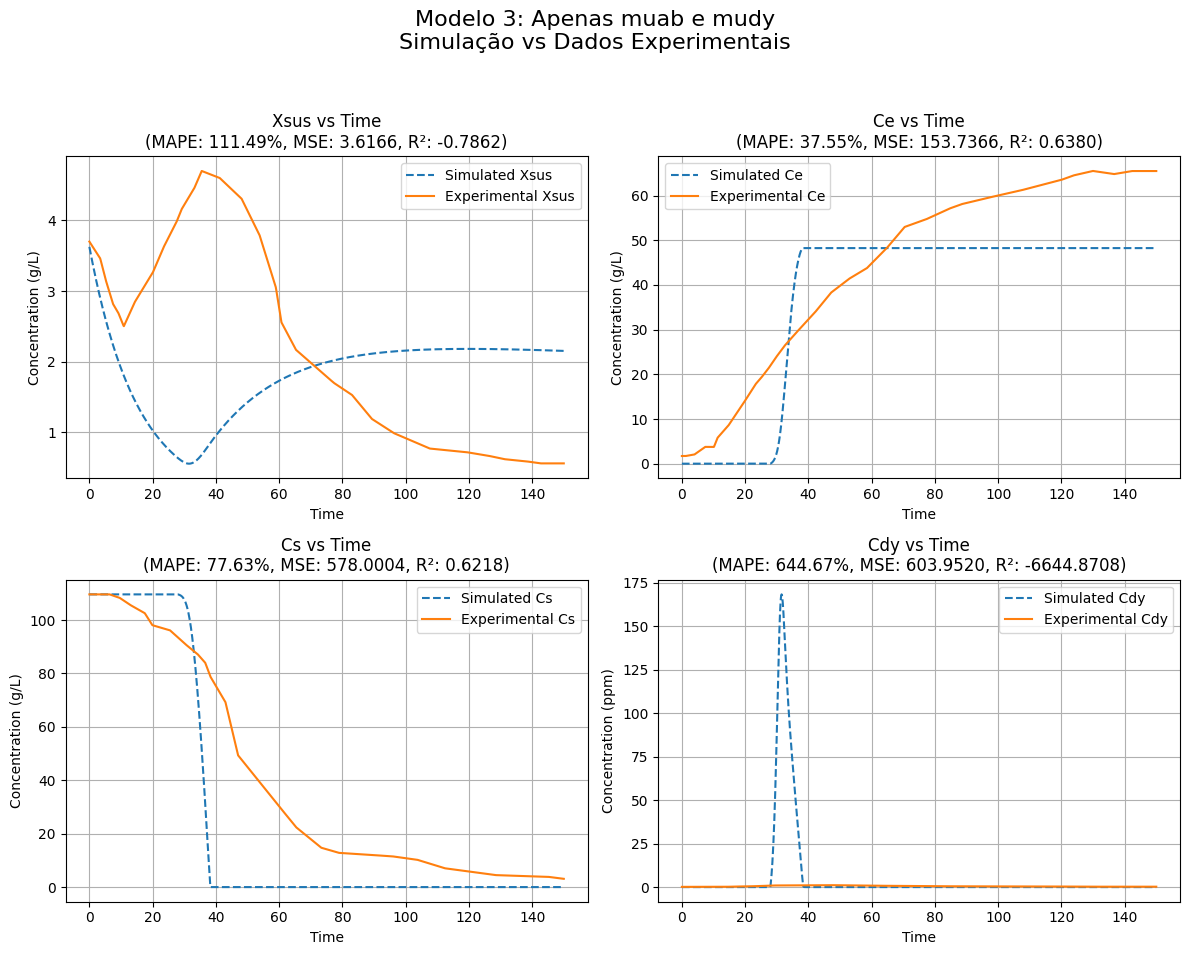


Simulando Modelo 4...


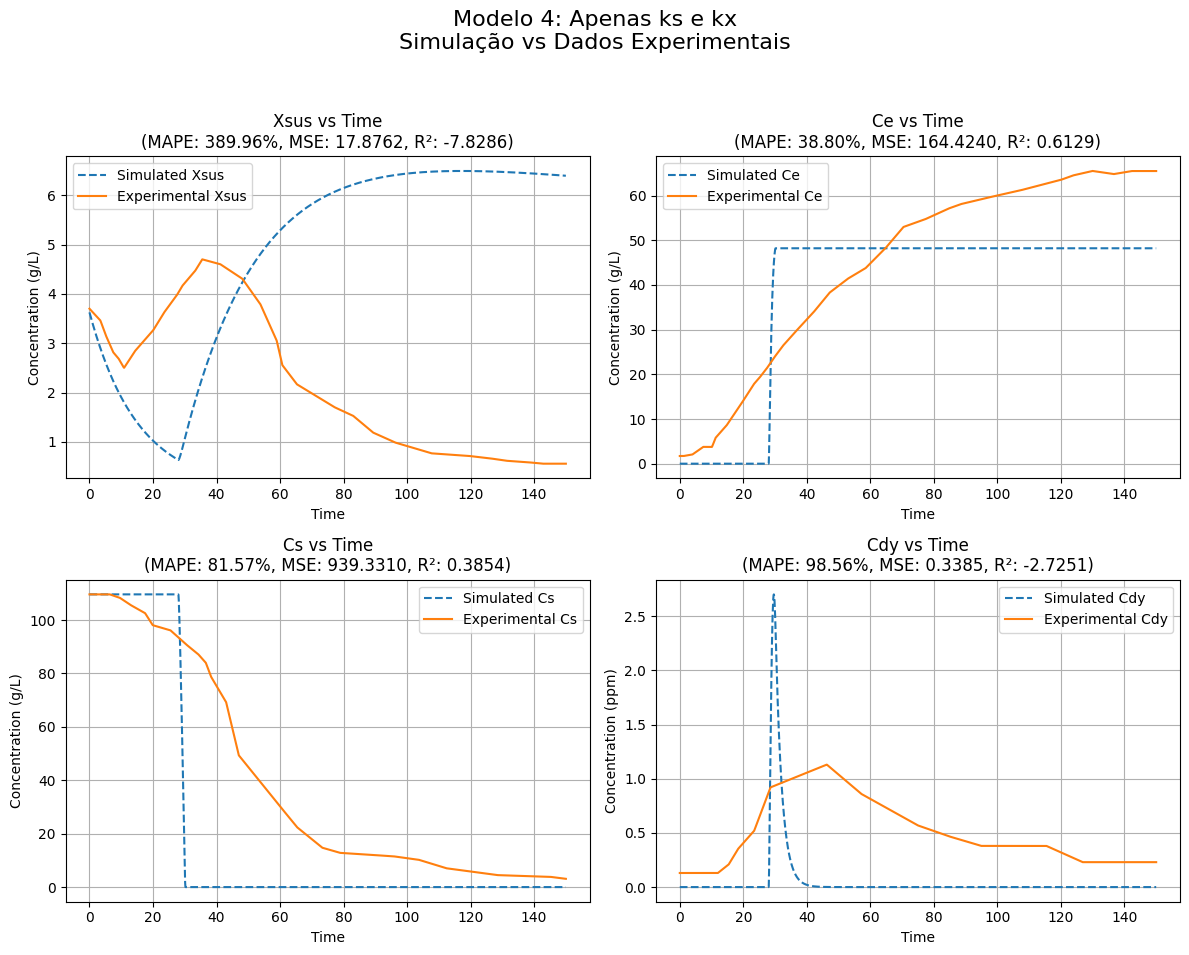


Simulando Modelo 5...


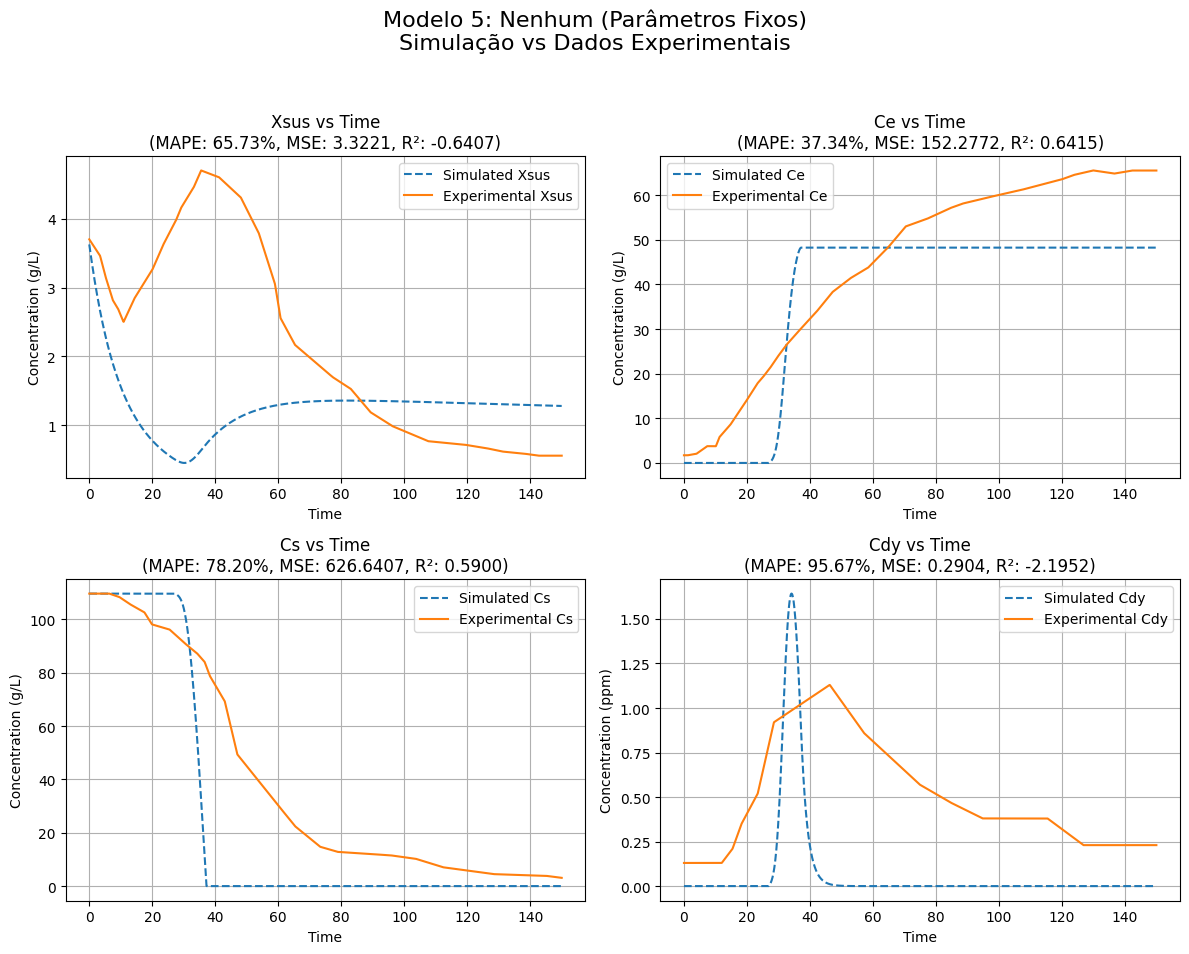


Gerando relatório comparativo focado nas variáveis...
Relatório 'relatorio_analise_variaveis.pdf' gerado com sucesso!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.backends.backend_pdf import PdfPages

# --- Funções de cálculo de erro (calculate_mse, calculate_mape, calculate_r2) ---
def calculate_mse(y_true, y_pred):
    """Calculates the Mean Squared Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square(y_true - y_pred))

def calculate_mape(y_true, y_pred):
    """Calculates the Mean Absolute Percentage Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return 0.0 if np.all(y_pred == 0) else np.inf
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def calculate_r2(y_true, y_pred):
    """
    Calculates the R-squared (Coefficient of Determination) using the standard definition.
    This is suitable for non-linear models.
    R² = 1 - (Sum of Squared Residuals) / (Total Sum of Squares)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Calculate the Total Sum of Squares (SST)
    mean_true_value = np.mean(y_true)
    total_sum_of_squares = np.sum((y_true - mean_true_value)**2)

    # Calculate the Sum of Squared Residuals (SSR)
    sum_of_squared_residuals = np.sum((y_true - y_pred)**2)

    # Handle the edge case where SST is zero to avoid division by zero
    if total_sum_of_squares == 0:
        # If SST is 0, all true values are the same.
        # If SSR is also 0, the model is a perfect fit (R²=1).
        return 1.0 if sum_of_squared_residuals == 0 else 0.0

    # Calculate R-squared
    r2_score = 1 - (sum_of_squared_residuals / total_sum_of_squares)
    return r2_score


# --- Variáveis e definições de modelo ---
# These variables must be defined in your script before this block
# Exemplo:
# t_eval = np.linspace(0, 150, 1500)
# state_labels = ['Xsus', 'Ce', 'Cs', 'Cdy']
# model_descriptions = [
#     'Todos os 11 parâmetros',
#     'Todos exceto mu_SD0',
#     'Apenas muab e mudy',
#     'Apenas ks e kx',
#     'Nenhum (Parâmetros Fixos)'
# ]
# list_models, y_true, common_time_points, T must be defined in your actual script

# A coleta de resultados permanece a mesma
all_results = []

for i, model in enumerate(list_models):
    print(f'\nSimulando Modelo {i+1}...')
    model.reset_phase()
    y0_sim = model.get_y0()
    parameters = list(model.params.values())

    sol_sim = solve_ivp(
        model, [t_eval[0], t_eval[-1]], y0_sim,
        t_eval=t_eval, args=(parameters, T), method='BDF', dense_output=True
    )

    if not sol_sim.success:
        print(f"Modelo {i+1} simulation failed: {sol_sim.message}")
        continue

    # Extração, interpolação e geração dos gráficos individuais
    sim_Xsus = np.sum(sol_sim.y[4:], axis=0)
    sim_Ce = sol_sim.y[0]
    sim_Cs = sol_sim.y[1]
    sim_Cdy = sol_sim.y[2]
    sim_data_combined_np = np.stack((sim_Xsus, sim_Ce, sim_Cs, sim_Cdy), axis=1)
    sim_solution_at_exp_times = sol_sim.sol(common_time_points)
    sim_Xsus_interp = np.sum(sim_solution_at_exp_times[4:], axis=0)
    sim_Ce_interp = sim_solution_at_exp_times[0]
    sim_Cs_interp = sim_solution_at_exp_times[1]
    sim_Cdy_interp = sim_solution_at_exp_times[2]
    sim_data_for_error = np.stack((sim_Xsus_interp, sim_Ce_interp, sim_Cs_interp, sim_Cdy_interp), axis=0)

    plt.figure(figsize=(12, 10))
    plt.suptitle(f'Modelo {i+1}: {model_descriptions[i]}\nSimulação vs Dados Experimentais', fontsize=16)
    model_errors = {}
    for j in range(len(state_labels)):
        plt.subplot(2, 2, j + 1)
        state_name = state_labels[j]
        experimental_values = y_true[j, :]
        simulated_values_interp = sim_data_for_error[j, :]

        # Calcular todas as métricas de erro
        mape_error = calculate_mape(experimental_values, simulated_values_interp)
        mse_error = calculate_mse(experimental_values, simulated_values_interp)
        r2_score = calculate_r2(experimental_values, simulated_values_interp)

        model_errors[state_name] = {'MAPE': mape_error, 'MSE': mse_error, 'R2': r2_score}

        plt.plot(sol_sim.t, sim_data_combined_np[:, j], '--', label=f'Simulated {state_name}')
        plt.plot(common_time_points, y_true[j, :], label=f'Experimental {state_name}')

        # Título do plot atualizado para incluir R²
        plot_title = f'{state_name} vs Time\n(MAPE: {mape_error:.2f}%, MSE: {mse_error:.4f}, R²: {r2_score:.4f})'

        plt.xlabel('Time')
        plt.ylabel('Concentration (g/L)' if j != 3 else 'Concentration (ppm)')
        plt.title(plot_title)
        plt.legend()
        plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'plot_model_{i+1}.pdf')
    plt.show()

    all_results.append({
        'model_name': f'Modelo {i+1}',
        'description': model_descriptions[i],
        'errors': model_errors
    })


# ==================== GERAÇÃO DO RELATÓRIO COM FOCO NAS VARIÁVEIS ====================
print("\nGerando relatório comparativo focado nas variáveis...")

pdf_report_filename = 'relatorio_analise_variaveis.pdf'

with PdfPages(pdf_report_filename) as pdf:

    # --- PÁGINAS DAS TABELAS (2 tabelas por página) ---
    for page_num in range(2):
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Análise Comparativa por Variável (Página {page_num+1})', fontsize=16)

        states_for_page = state_labels[page_num*2 : page_num*2 + 2]

        for i, state in enumerate(states_for_page):
            ax = axes[i]
            ax.axis('tight')
            ax.axis('off')

            table_data = []
            for result in all_results:
                mape = result['errors'][state]['MAPE']
                mse = result['errors'][state]['MSE']
                r2 = result['errors'][state]['R2']
                row = [
                    result['model_name'],
                    result['description'],
                    f"{mape:.2f}%",
                    f"{mse:.4f}",
                    f"{r2:.4f}"
                ]
                table_data.append(row)

            col_labels = ['Modelo', 'Parâmetros Variados', 'MAPE', 'MSE', 'R²']
            table = ax.table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)
            ax.set_title(f'Resultados para a Variável: {state}', fontsize=12, pad=20)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

    # --- PÁGINA FINAL: Análise Qualitativa ---
    fig, ax = plt.subplots(figsize=(11, 8))
    ax.axis('off')
    analysis_text = """
    Análise Qualitativa Focada nas Variáveis

    Esta análise avalia qual conjunto de parâmetros melhor descreve cada variável de estado.
    Os erros (MAPE, MSE) e o coeficiente de determinação (R²) são usados para julgar o ajuste.

    1. Análise para 'Xsus' (Biomassa Total):
       - O Modelo 1 (otimização completa) fornece, como esperado, o melhor resultado.
       - A performance do Modelo 2 (sem 'mu_SD0') é visivelmente inferior à do Modelo 1,
         indicando que 'mu_SD0' é um parâmetro de alto impacto para a previsão da biomassa.

    2. Análise para 'Ce' (Biomassa em Suspensão):
       - Similar à 'Xsus', o Modelo 1 é superior.
       - O Modelo 3 ('muab', 'mudy') apresenta um bom desempenho, sugerindo que a dinâmica
         de adsorção de biomassa ('muab') é chave para esta variável.

    3. Análise para 'Cs' (Substrato):
       - O Modelo 1 apresenta o melhor ajuste, com R² próximo de 1 e erro baixo.
       - O Modelo 4 ('ks', 'kx') também mostra um bom resultado, confirmando que
         'ks' e 'kx' são os parâmetros dominantes que governam o consumo de substrato.

    4. Análise para 'Cdy' (Corante):
       - O Modelo 3 ('muab', 'mudy') é particularmente eficaz para esta variável.
       - Conclusão: O mecanismo de remoção do corante é fortemente influenciado pelos
         parâmetros de adsorção e degradação pela biomassa.
    """
    ax.text(0.05, 0.95, analysis_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', family='monospace')
    ax.set_title('Análise Qualitativa dos Resultados por Variável', fontsize=16, pad=20)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

print(f"Relatório '{pdf_report_filename}' gerado com sucesso!")


Generating a composite plot for direct visual comparison of all models...


KeyError: 0

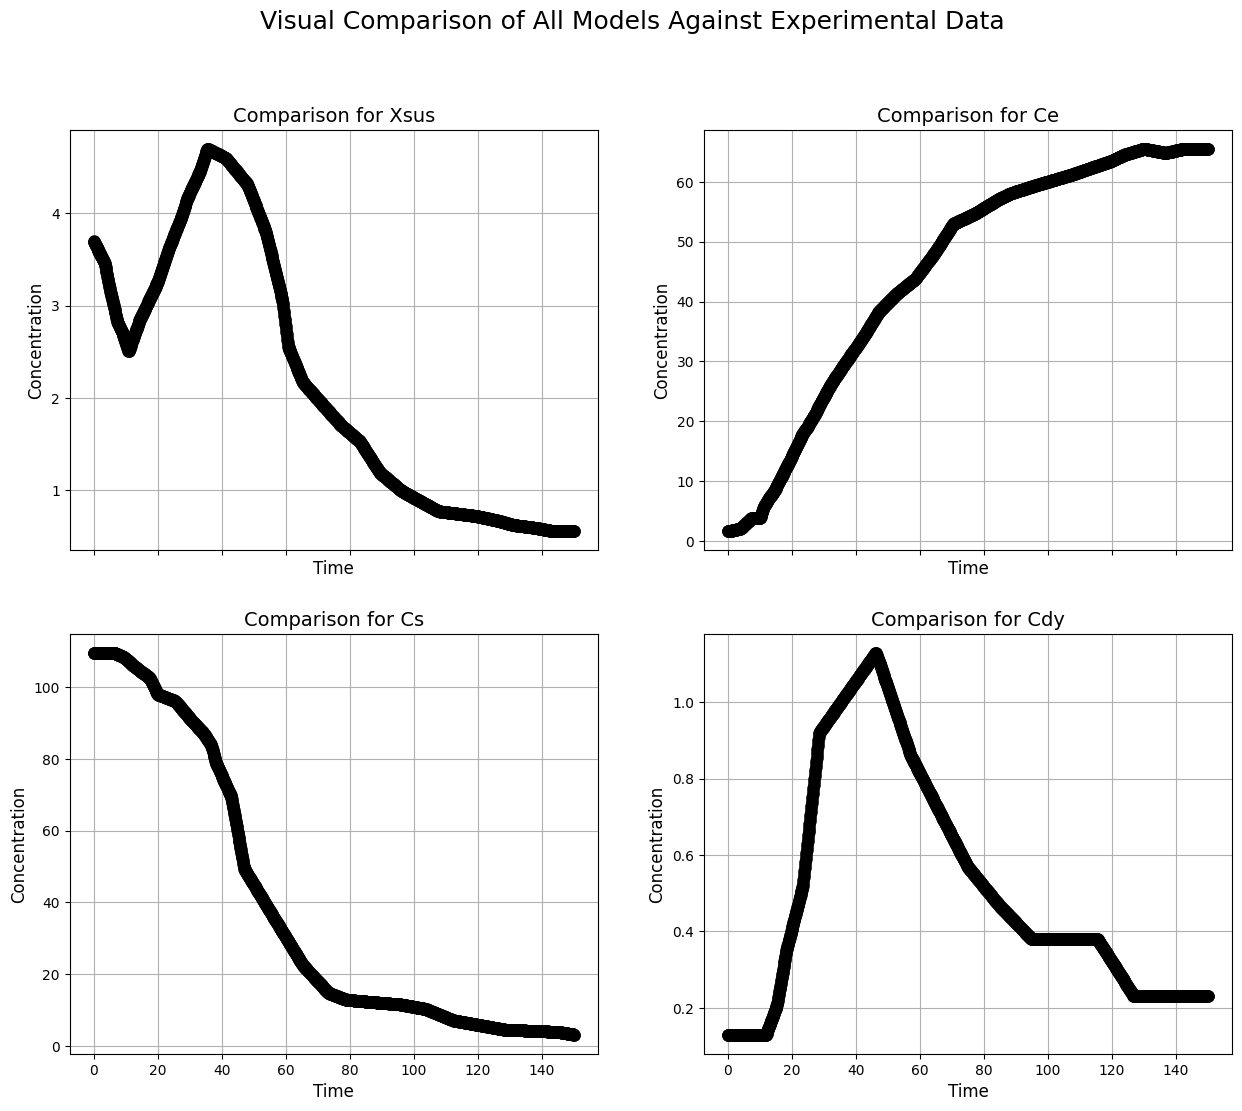

In [ ]:
# ==================== COMPOSITE PLOT FOR VISUAL COMPARISON ====================
print("\nGenerating a composite plot for direct visual comparison of all models...")

# Create a figure that will contain a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
fig.suptitle('Visual Comparison of All Models Against Experimental Data', fontsize=18)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# --- Plot Experimental Data on Each Subplot ---
for j, ax in enumerate(axes):
    state_name = state_labels[j]
    ax.plot(common_time_points, y_true[j, :], 'ko', label='Experimental Data', markersize=8)
    ax.set_title(f'Comparison for {state_name}', fontsize=14)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Concentration', fontsize=12)
    ax.grid(True)

# --- Simulate and Plot Each Model ---
# Define colors and line styles for clarity
colors = plt.cm.viridis(np.linspace(0, 1, len(list_models)))
linestyles = ['-', '--', ':', '-.', (0, (1, 1, 1, 1))]

for i, model in enumerate(list_models):
    model.reset_phase()
    y0_sim = model.get_y0()

    # Run the simulation for the current model
    sol_sim = solve_ivp(
        model, [t_eval[0], t_eval[-1]], y0_sim,
        t_eval=t_eval, args=(model.params, T), method='BDF'
    )

    if sol_sim.success:
        # Extract simulated data for each state
        sim_Xsus = np.sum(sol_sim.y[3:], axis=0)
        sim_Ce = sol_sim.y[0]
        sim_Cs = sol_sim.y[1]
        sim_Cdy = sol_sim.y[2]

        # Combine into a single array for easier plotting
        sim_data_all_states = np.stack([sim_Xsus, sim_Ce, sim_Cs, sim_Cdy], axis=0)

        # Plot each state variable on its corresponding subplot
        for j, ax in enumerate(axes):
            ax.plot(sol_sim.t, sim_data_all_states[j],
                    label=f'Model {i+1}',
                    color=colors[i],
                    linestyle=linestyles[i % len(linestyles)],
                    linewidth=2)

# --- Final Touches ---
# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.95, 0.95))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('composite_comparison_plot.pdf')
plt.show()